In [ ]:
!pip install ultralytics
!pip install deep-sort-realtime
!pip install opencv-python-headless


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [ ]:
import cv2
import numpy as np
import os

os.makedirs("data", exist_ok=True)
out = cv2.VideoWriter("data/sample_video.mp4", cv2.VideoWriter_fourcc(*'mp4v'), 10, (640, 480))

for i in range(100):  # 10 seconds @ 10fps
    frame = np.zeros((480, 640, 3), dtype=np.uint8)

    # Person 1 (stationary)
    cv2.rectangle(frame, (300, 200), (350, 400), (0, 255, 0), 2)

    # Person 2 (moving closer)
    x = max(0, 400 - i * 3)
    cv2.rectangle(frame, (x, 200), (x + 50, 400), (0, 0, 255), 2)

    out.write(frame)

out.release()
print("✅ Sample video created.")


✅ Sample video created.


In [ ]:
from ultralytics import YOLO
import cv2

model = YOLO("yolov8n.pt")  # Pretrained on COCO

def detect_people(frame):
    results = model(frame, conf=0.5)[0]
    boxes = results.boxes.xyxy.cpu().numpy()
    classes = results.boxes.cls.cpu().numpy().astype(int)
    return boxes[classes == 0]  # class 0 is person


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 49.2MB/s]


In [ ]:
from deep_sort_realtime.deepsort_tracker import DeepSort

tracker = DeepSort(max_age=10)

def track_people(frame, detections):
    # Convert YOLO boxes to format: [x, y, w, h]
    ds_detections = []
    for box in detections:
        x1, y1, x2, y2 = box
        ds_detections.append(([x1, y1, x2 - x1, y2 - y1], 0.9, 'person'))

    tracks = tracker.update_tracks(ds_detections, frame=frame)
    output = []
    for t in tracks:
        if not t.is_confirmed():
            continue
        track_id = t.track_id
        x1, y1, x2, y2 = map(int, t.to_ltrb())
        output.append((track_id, [x1, y1, x2, y2]))
    return output


In [ ]:
from collections import defaultdict, deque
import numpy as np

history = defaultdict(lambda: deque(maxlen=10))

def check_stalker(tracks):
    alerts = []
    for track_id, bbox in tracks:
        cx = (bbox[0] + bbox[2]) / 2
        cy = (bbox[1] + bbox[3]) / 2
        history[track_id].append(np.array([cx, cy]))

    ids = list(history.keys())
    for i in range(len(ids)):
        for j in range(i + 1, len(ids)):
            dists = [
                np.linalg.norm(history[ids[i]][k] - history[ids[j]][k])
                for k in range(min(len(history[ids[i]]), len(history[ids[j]])))
            ]
            if len(dists) == 10 and all(d < 50 for d in dists):
                alerts.append((ids[i], ids[j]))
    return alerts



0: 480x640 (no detections), 9.5ms
Speed: 2.9ms preprocess, 9.5ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


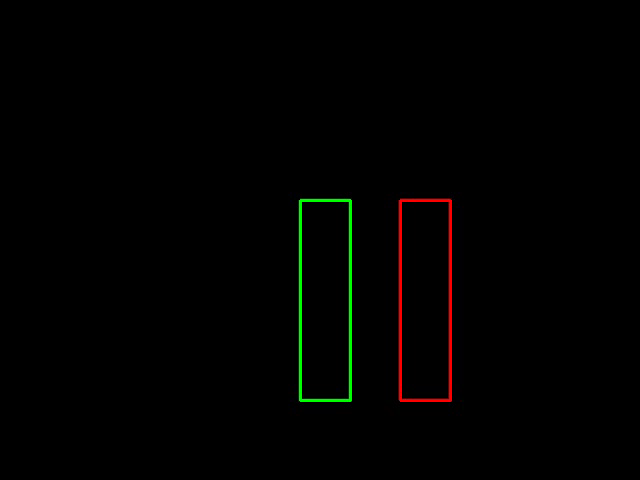


0: 480x640 (no detections), 14.4ms
Speed: 2.7ms preprocess, 14.4ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)


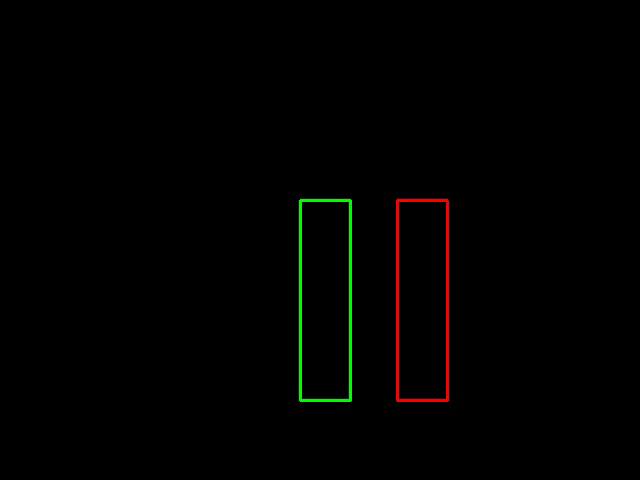


0: 480x640 (no detections), 12.2ms
Speed: 2.3ms preprocess, 12.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


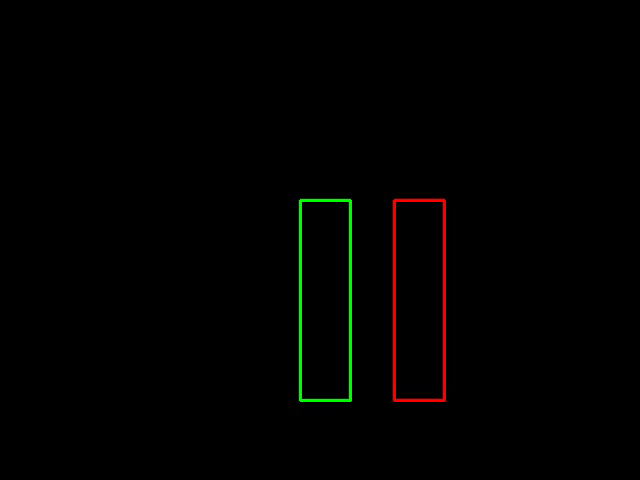


0: 480x640 (no detections), 10.3ms
Speed: 2.0ms preprocess, 10.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


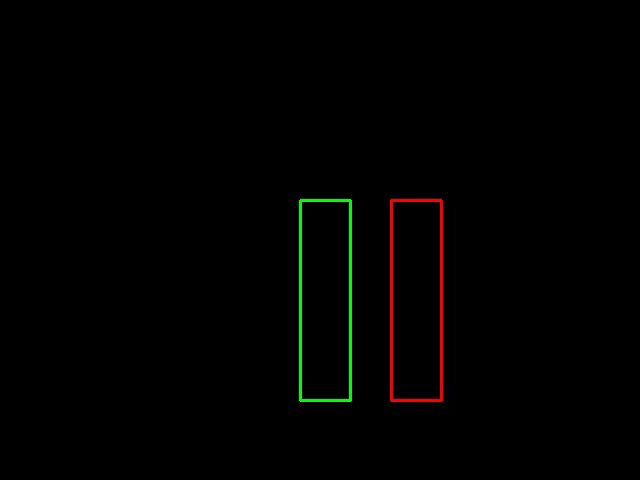


0: 480x640 (no detections), 10.7ms
Speed: 2.0ms preprocess, 10.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


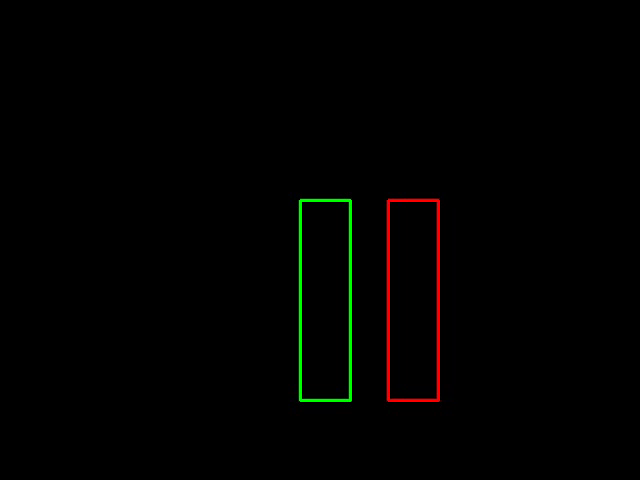


0: 480x640 (no detections), 11.3ms
Speed: 2.2ms preprocess, 11.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


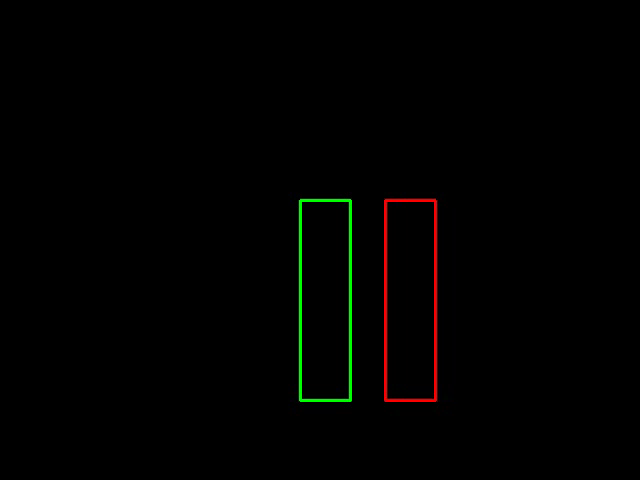


0: 480x640 (no detections), 10.8ms
Speed: 2.0ms preprocess, 10.8ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


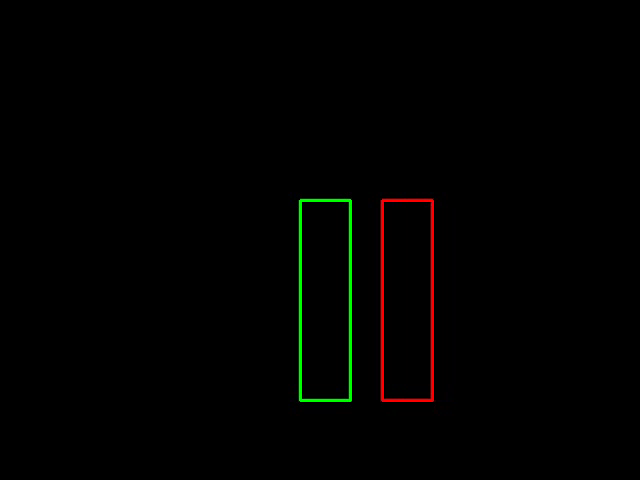


0: 480x640 (no detections), 12.5ms
Speed: 2.6ms preprocess, 12.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


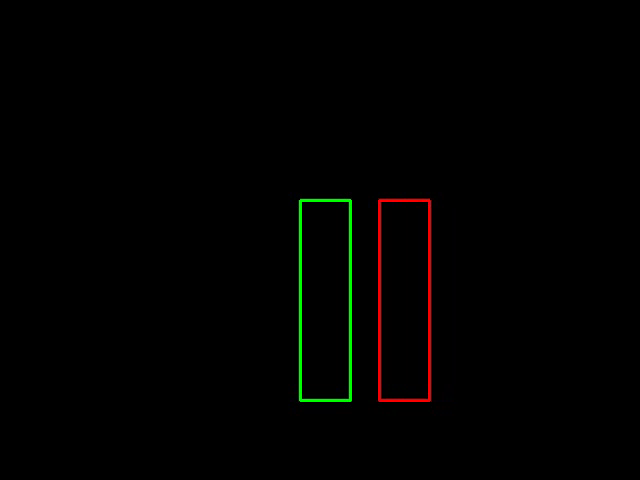


0: 480x640 (no detections), 10.7ms
Speed: 2.1ms preprocess, 10.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


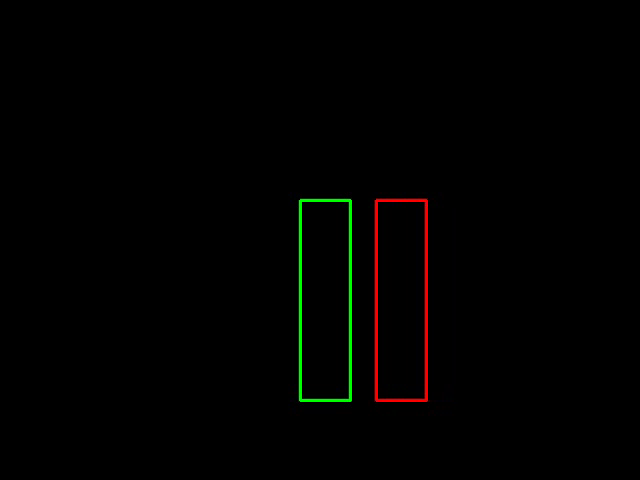


0: 480x640 (no detections), 9.2ms
Speed: 2.1ms preprocess, 9.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


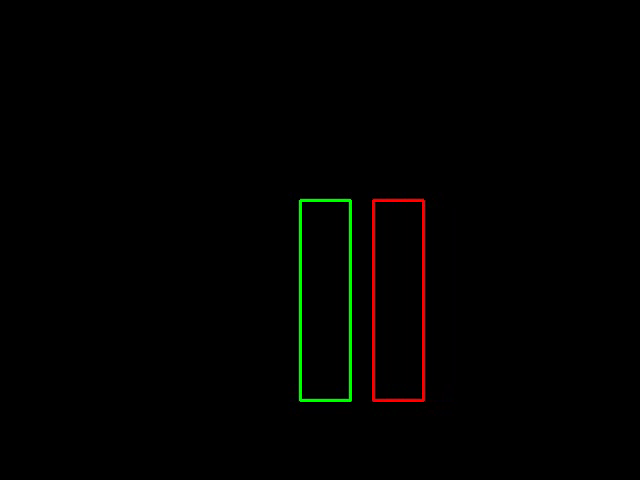


0: 480x640 (no detections), 12.3ms
Speed: 2.1ms preprocess, 12.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


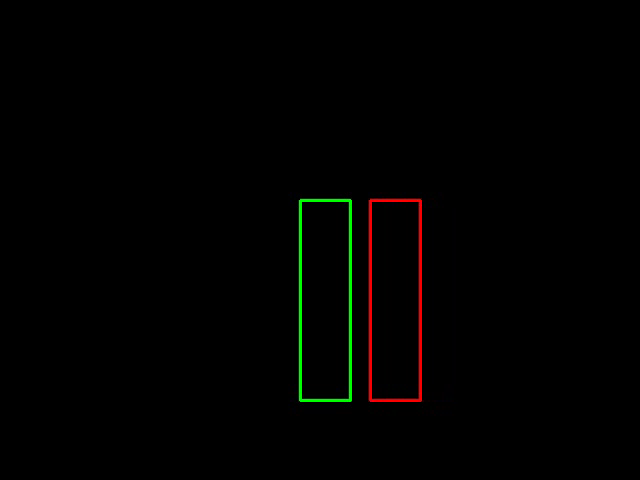


0: 480x640 (no detections), 9.5ms
Speed: 3.3ms preprocess, 9.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


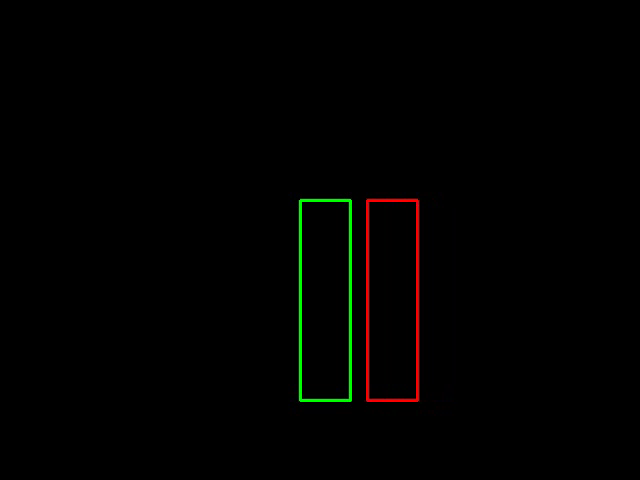


0: 480x640 (no detections), 11.4ms
Speed: 2.0ms preprocess, 11.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


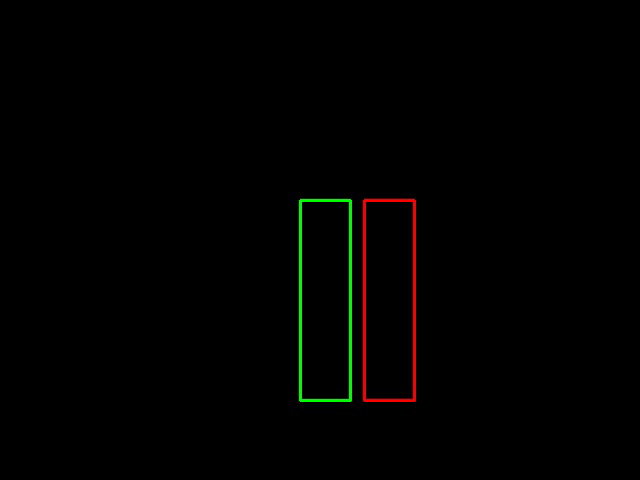


0: 480x640 (no detections), 11.0ms
Speed: 2.8ms preprocess, 11.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


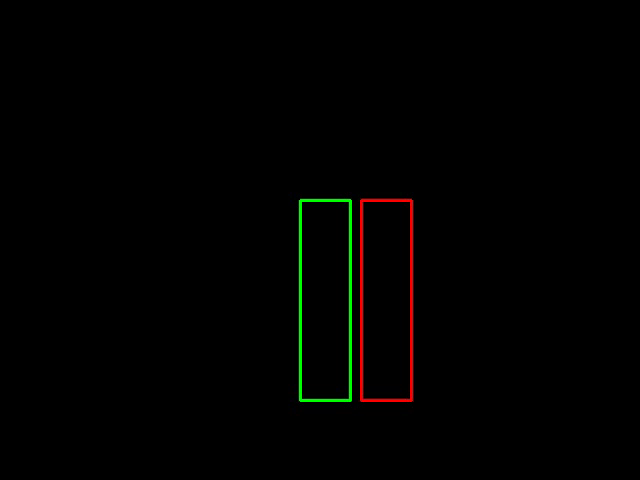


0: 480x640 (no detections), 13.8ms
Speed: 2.2ms preprocess, 13.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


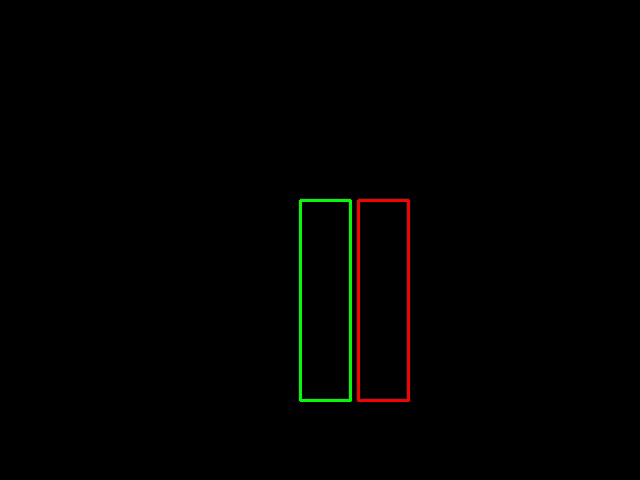


0: 480x640 (no detections), 11.6ms
Speed: 2.0ms preprocess, 11.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


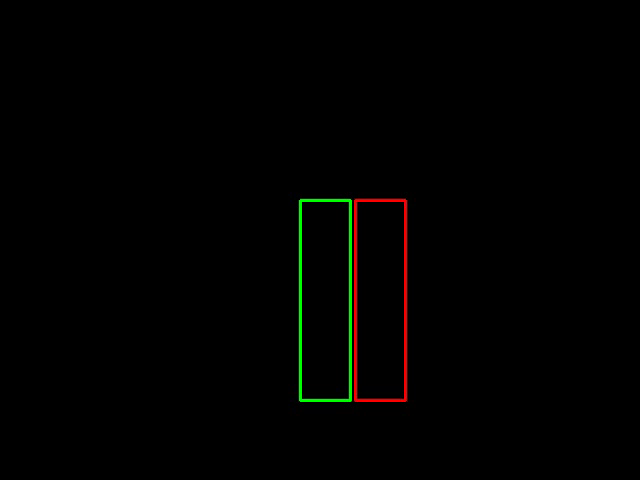


0: 480x640 (no detections), 10.3ms
Speed: 2.5ms preprocess, 10.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


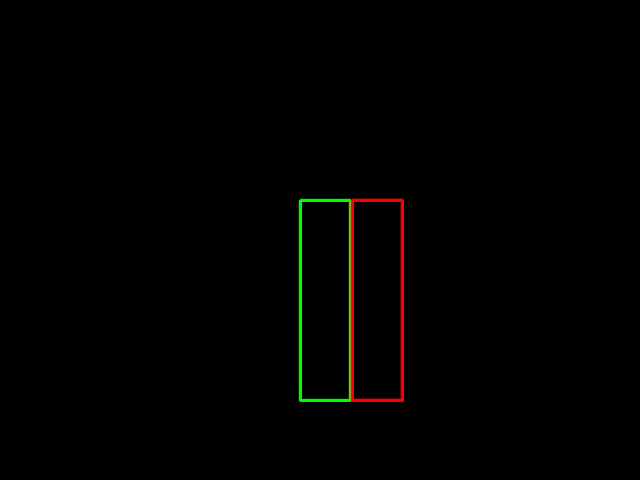


0: 480x640 (no detections), 9.0ms
Speed: 2.2ms preprocess, 9.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


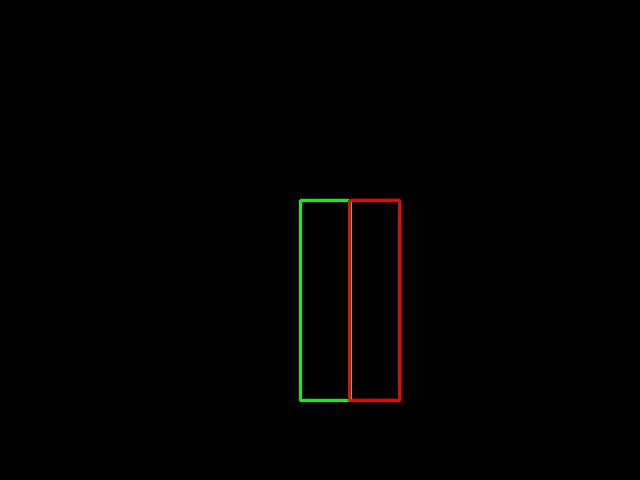


0: 480x640 (no detections), 9.9ms
Speed: 2.2ms preprocess, 9.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


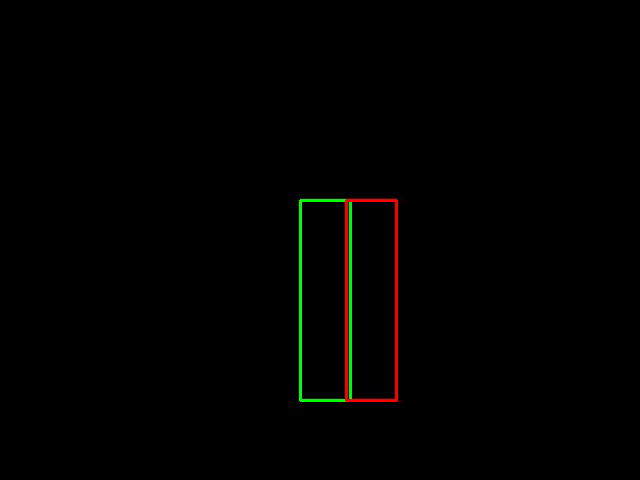


0: 480x640 (no detections), 9.8ms
Speed: 2.2ms preprocess, 9.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


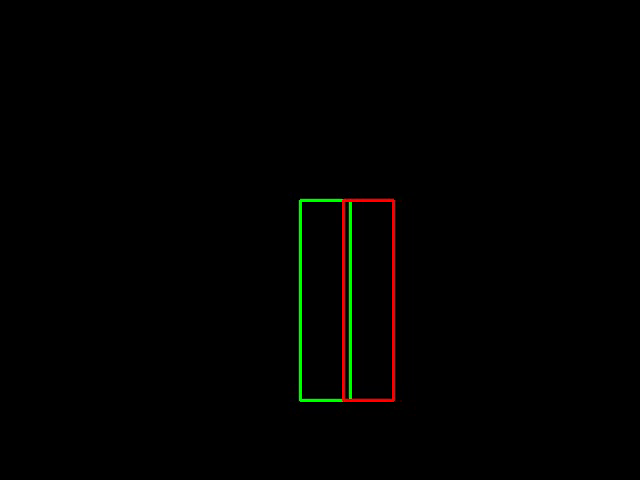


0: 480x640 (no detections), 10.9ms
Speed: 3.1ms preprocess, 10.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


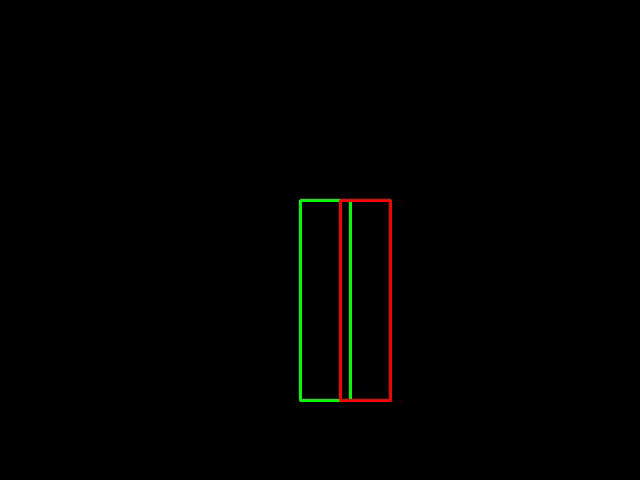


0: 480x640 (no detections), 9.7ms
Speed: 2.9ms preprocess, 9.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


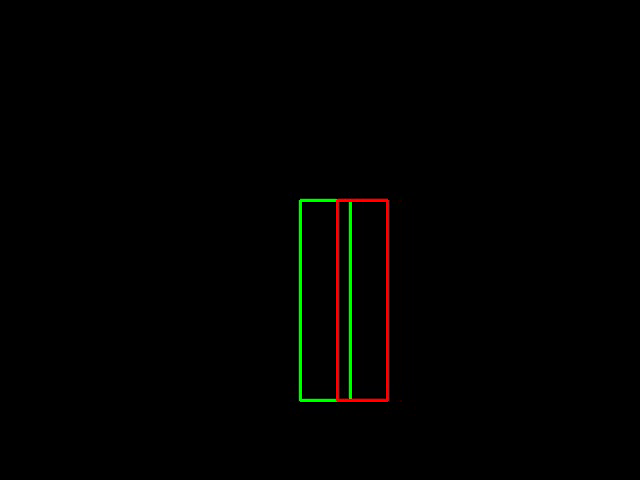


0: 480x640 (no detections), 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


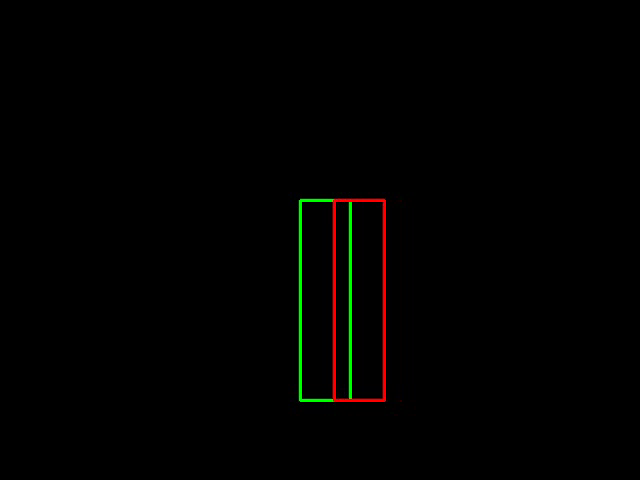


0: 480x640 (no detections), 16.0ms
Speed: 1.7ms preprocess, 16.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


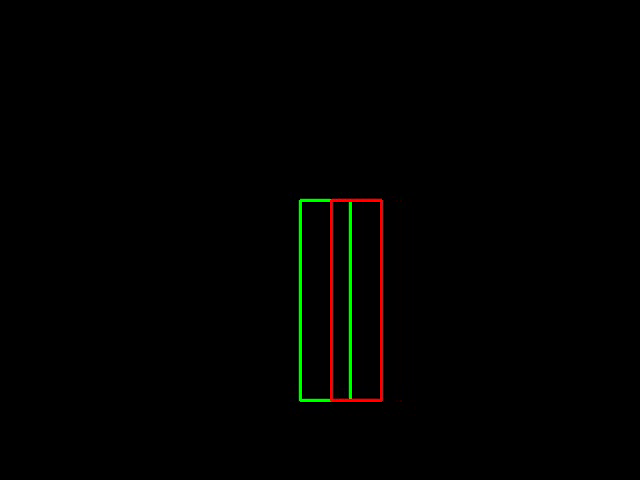


0: 480x640 (no detections), 12.3ms
Speed: 1.8ms preprocess, 12.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


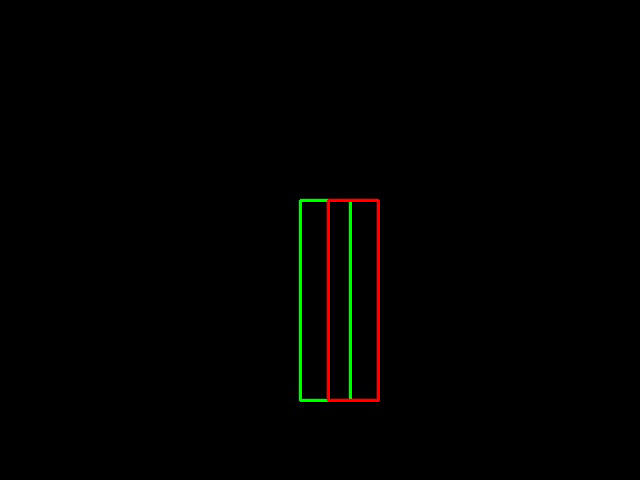


0: 480x640 (no detections), 10.6ms
Speed: 2.1ms preprocess, 10.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


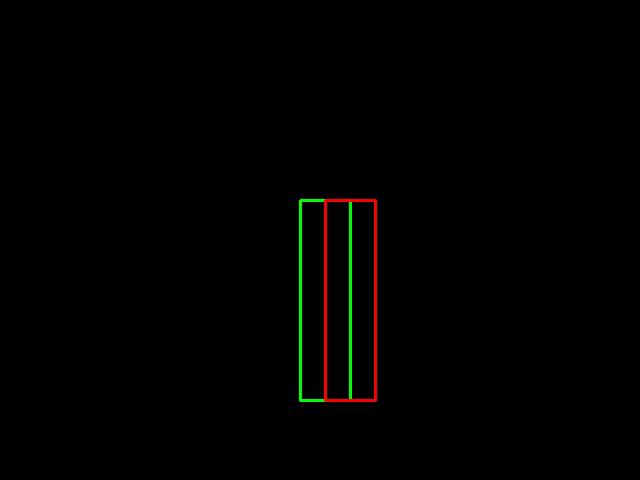


0: 480x640 (no detections), 10.0ms
Speed: 2.3ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


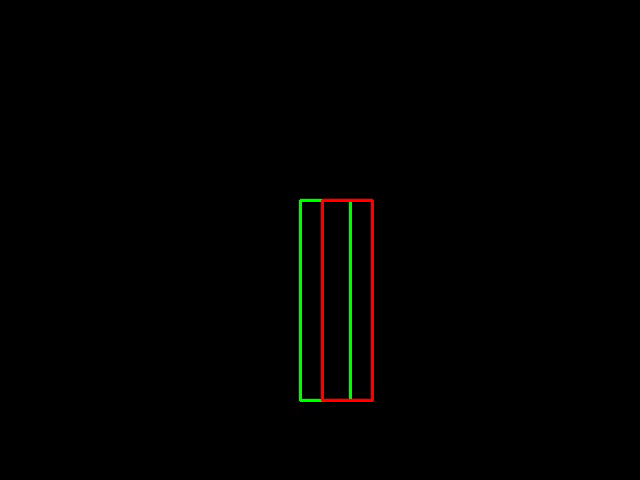


0: 480x640 (no detections), 9.5ms
Speed: 2.4ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


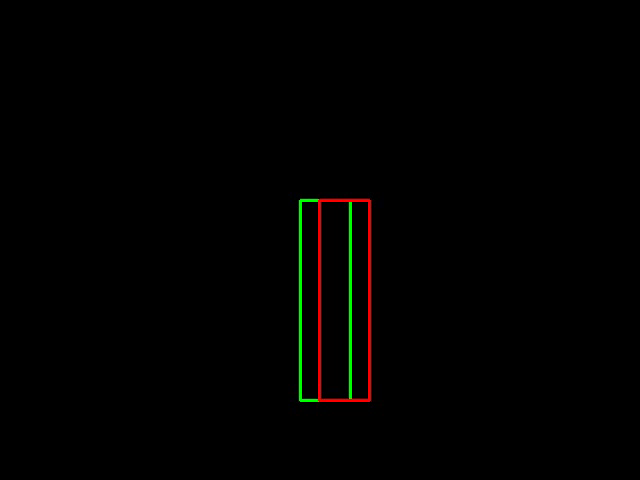


0: 480x640 (no detections), 9.7ms
Speed: 2.3ms preprocess, 9.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


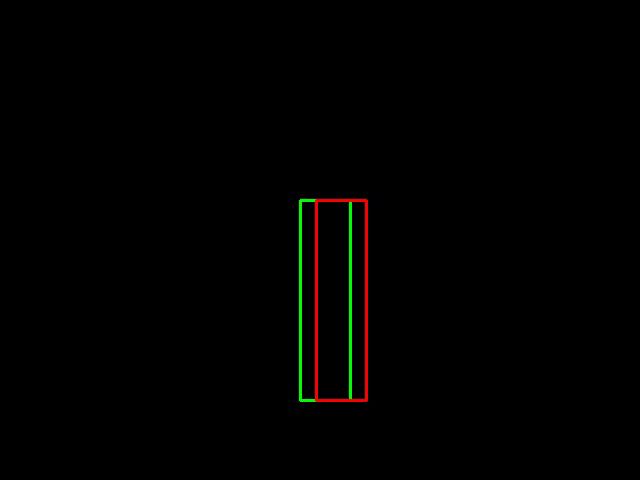


0: 480x640 (no detections), 9.6ms
Speed: 2.4ms preprocess, 9.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


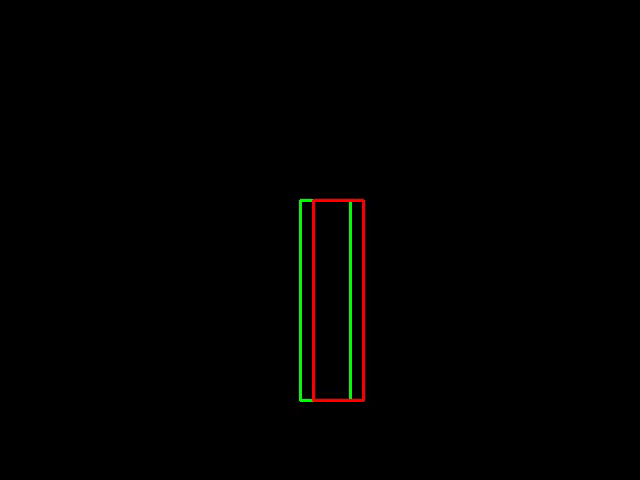


0: 480x640 (no detections), 9.4ms
Speed: 2.2ms preprocess, 9.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


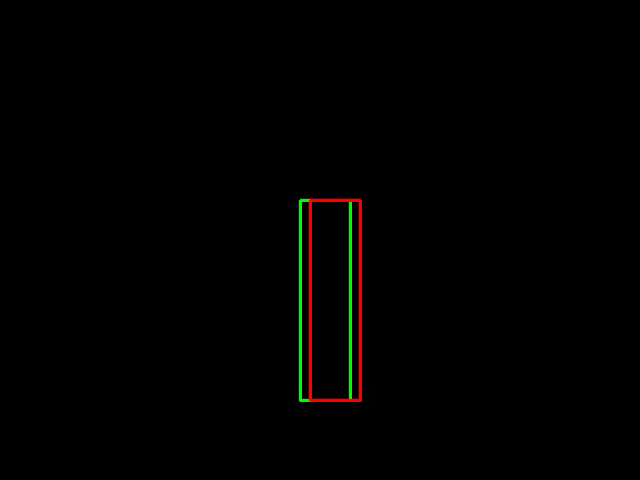


0: 480x640 (no detections), 9.2ms
Speed: 2.3ms preprocess, 9.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


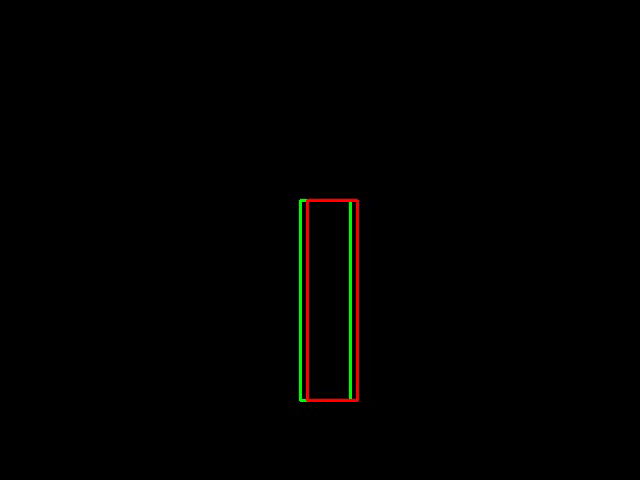


0: 480x640 (no detections), 9.6ms
Speed: 2.2ms preprocess, 9.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


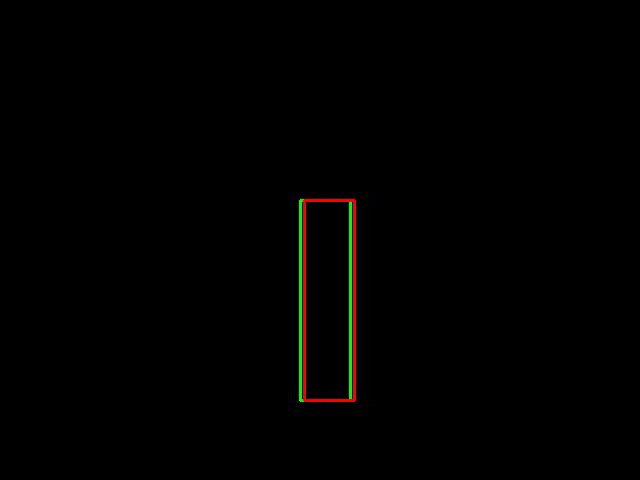


0: 480x640 (no detections), 10.6ms
Speed: 2.2ms preprocess, 10.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


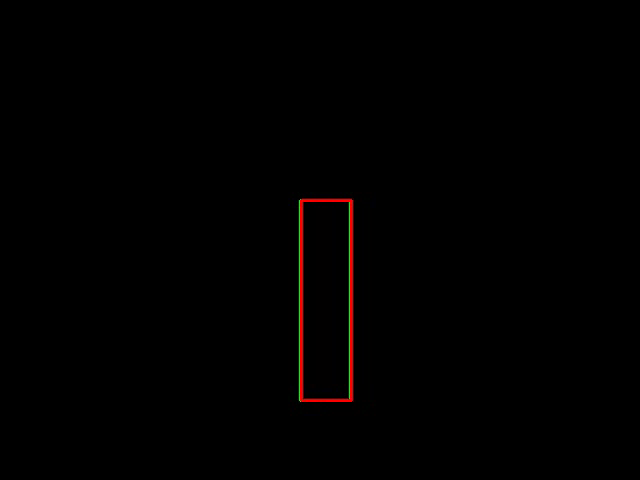


0: 480x640 (no detections), 11.5ms
Speed: 5.8ms preprocess, 11.5ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)


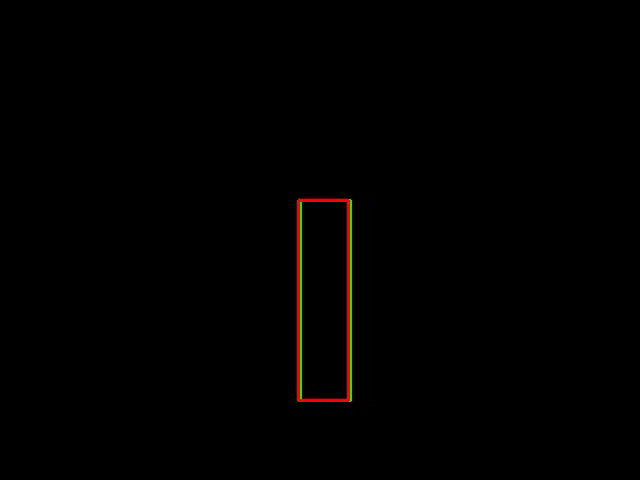


0: 480x640 (no detections), 13.2ms
Speed: 2.2ms preprocess, 13.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


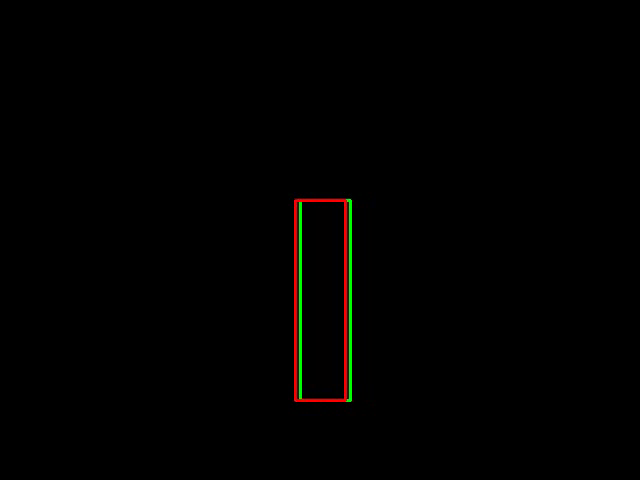


0: 480x640 (no detections), 9.9ms
Speed: 2.1ms preprocess, 9.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


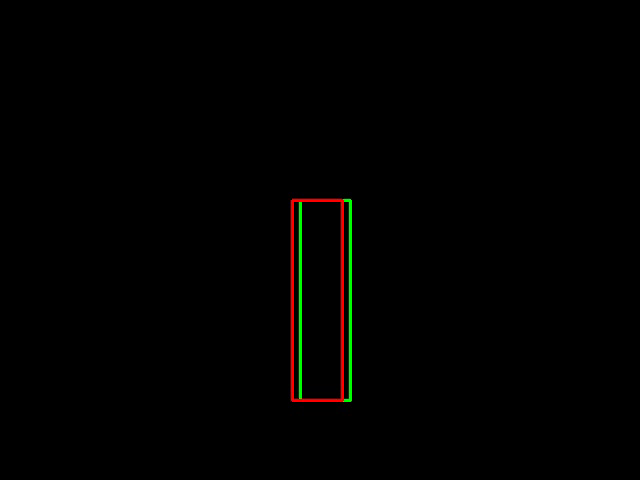


0: 480x640 (no detections), 9.4ms
Speed: 2.2ms preprocess, 9.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


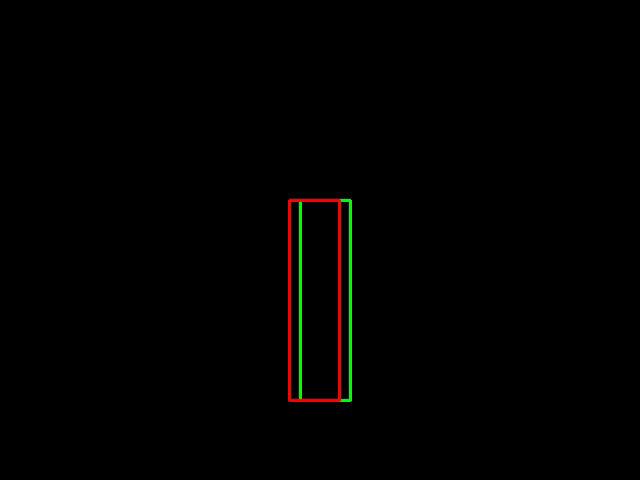


0: 480x640 (no detections), 10.9ms
Speed: 2.2ms preprocess, 10.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


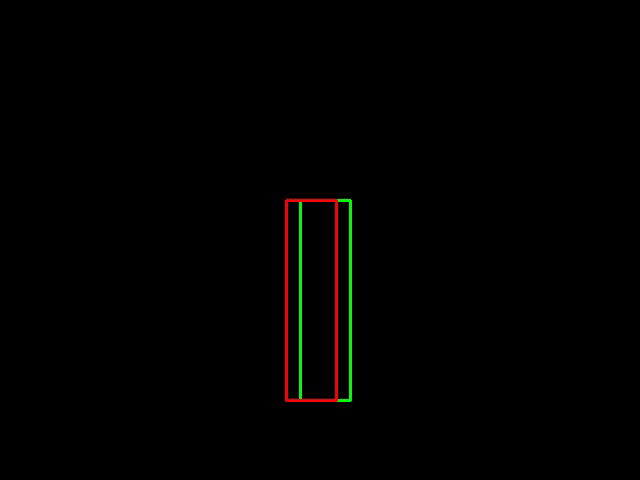


0: 480x640 (no detections), 9.3ms
Speed: 2.1ms preprocess, 9.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


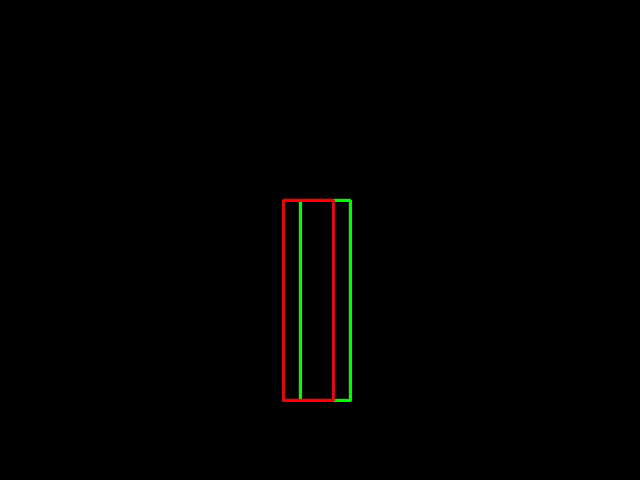


0: 480x640 (no detections), 8.9ms
Speed: 2.1ms preprocess, 8.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


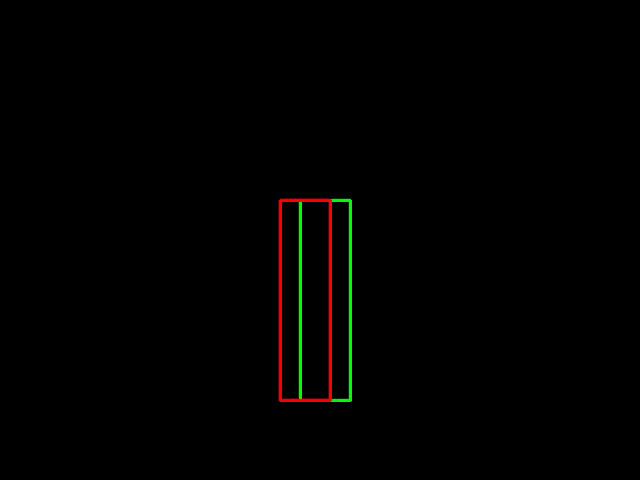


0: 480x640 (no detections), 9.5ms
Speed: 2.2ms preprocess, 9.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


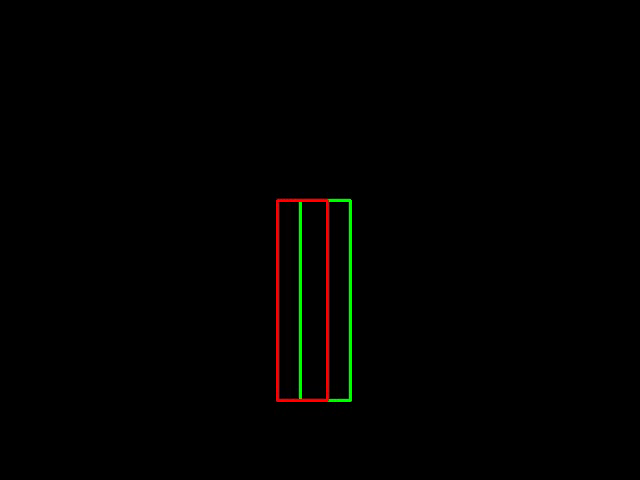


0: 480x640 (no detections), 9.5ms
Speed: 2.4ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


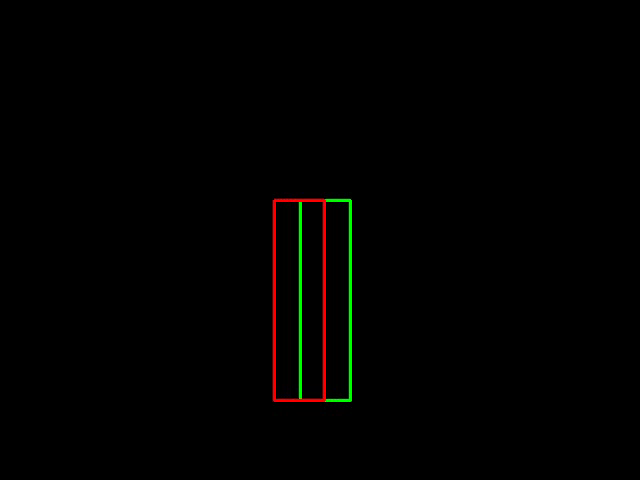


0: 480x640 (no detections), 9.6ms
Speed: 2.2ms preprocess, 9.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


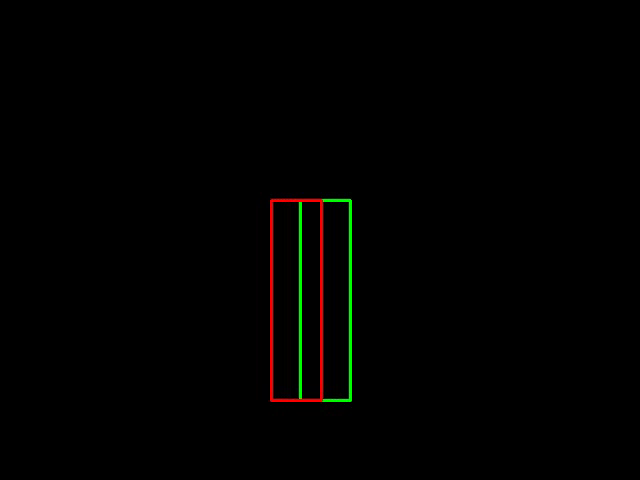


0: 480x640 (no detections), 11.5ms
Speed: 2.2ms preprocess, 11.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


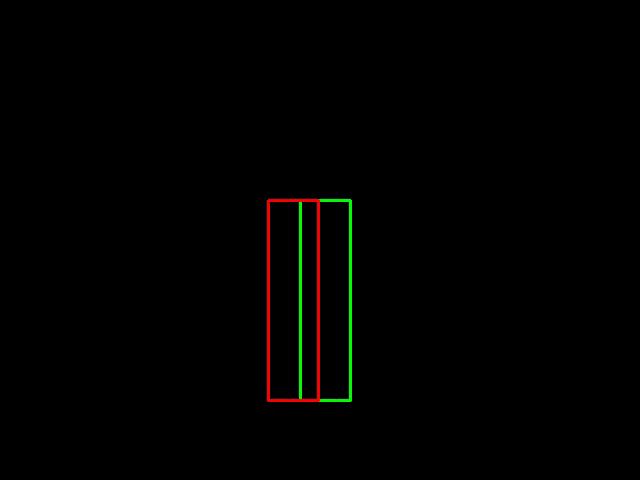


0: 480x640 (no detections), 9.7ms
Speed: 2.3ms preprocess, 9.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


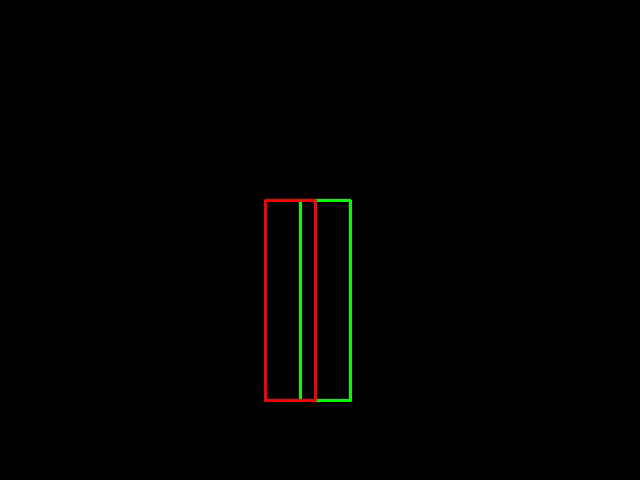


0: 480x640 (no detections), 11.4ms
Speed: 2.7ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


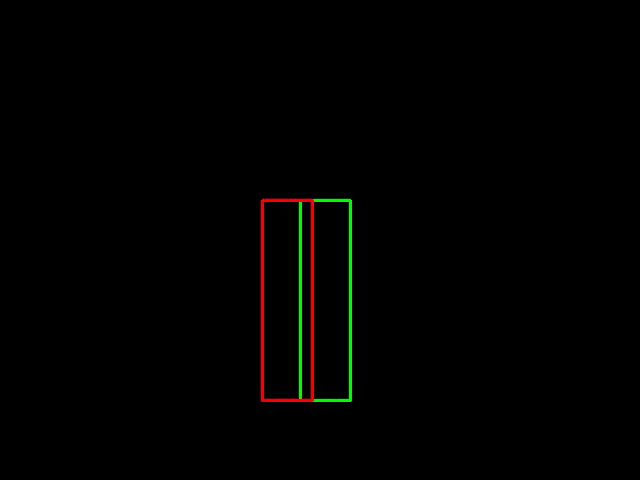


0: 480x640 (no detections), 11.2ms
Speed: 2.2ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


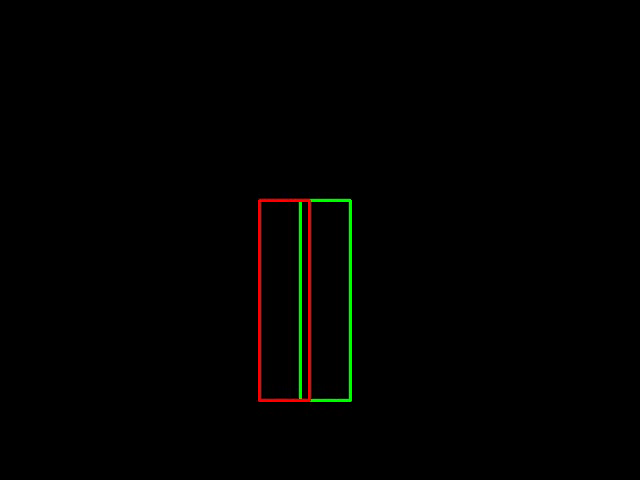


0: 480x640 (no detections), 9.6ms
Speed: 2.4ms preprocess, 9.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


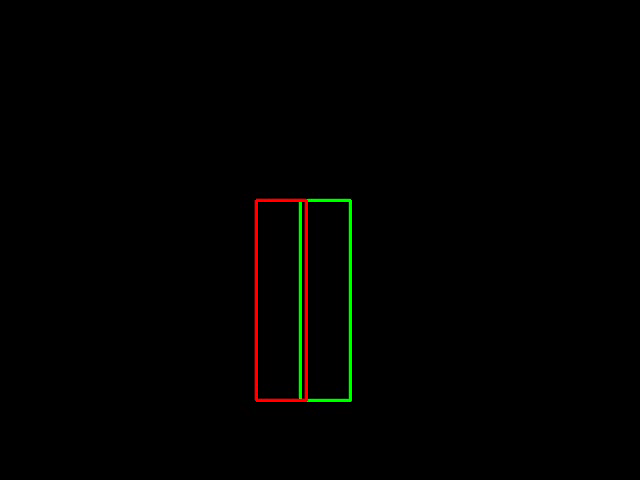


0: 480x640 (no detections), 9.8ms
Speed: 2.4ms preprocess, 9.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


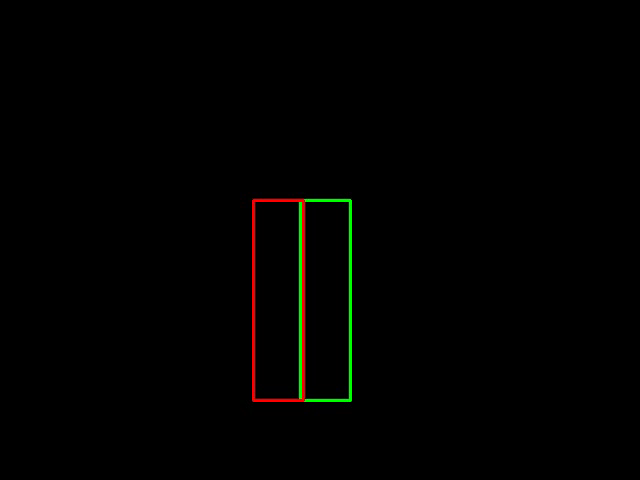


0: 480x640 (no detections), 9.4ms
Speed: 2.3ms preprocess, 9.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


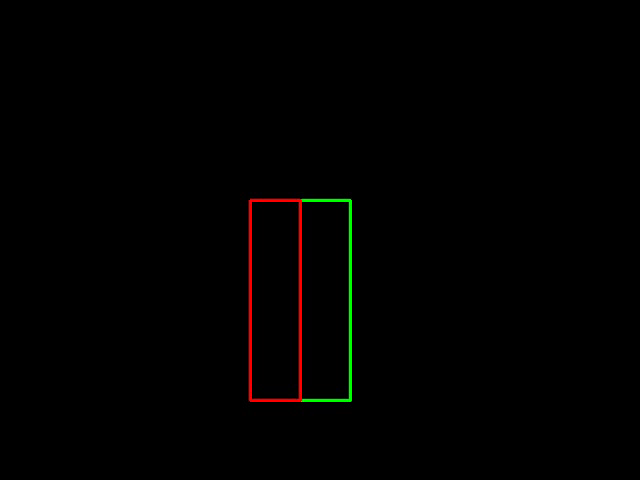


0: 480x640 (no detections), 9.6ms
Speed: 2.2ms preprocess, 9.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


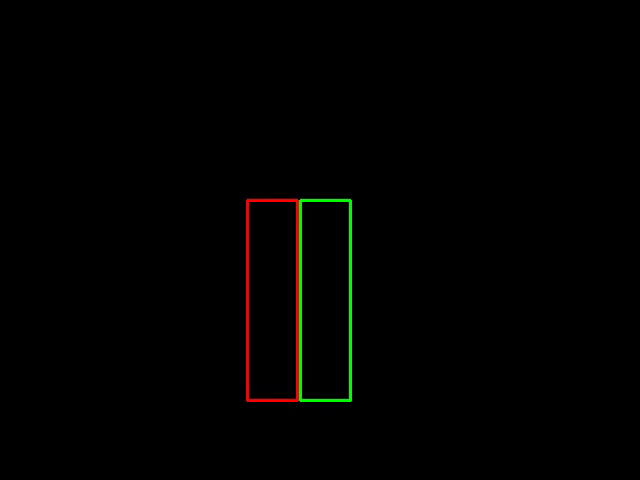


0: 480x640 (no detections), 9.7ms
Speed: 2.4ms preprocess, 9.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


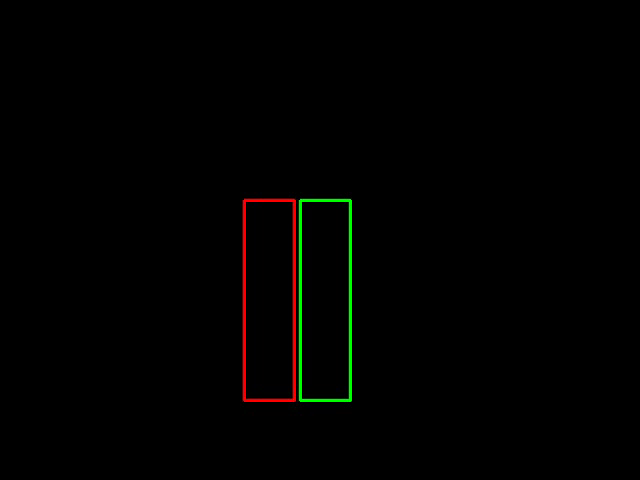


0: 480x640 (no detections), 9.5ms
Speed: 2.4ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


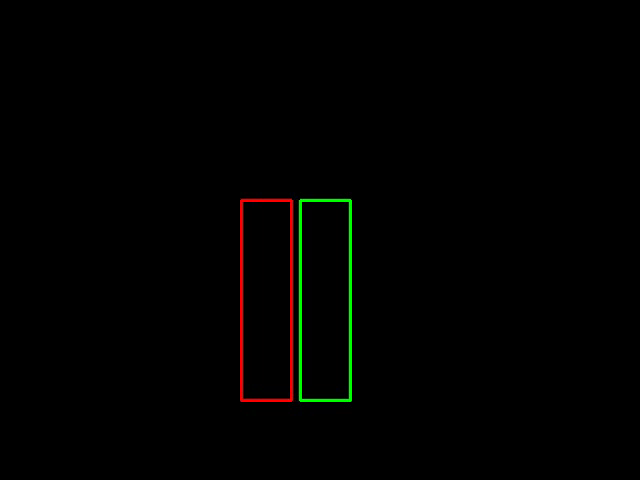


0: 480x640 (no detections), 9.7ms
Speed: 2.2ms preprocess, 9.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


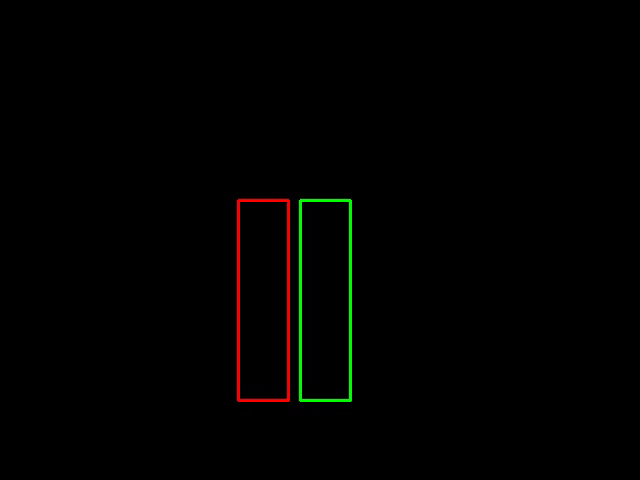


0: 480x640 (no detections), 10.0ms
Speed: 2.5ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


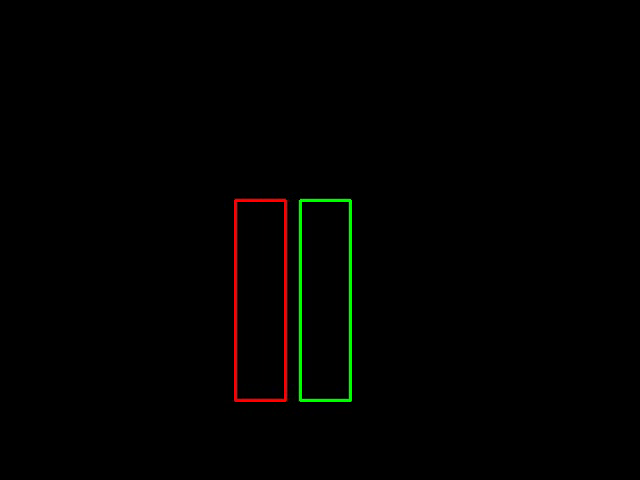


0: 480x640 (no detections), 9.5ms
Speed: 2.2ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


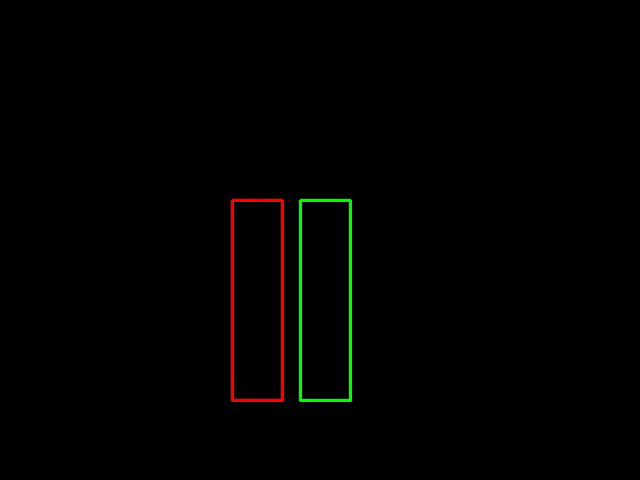


0: 480x640 (no detections), 9.1ms
Speed: 2.2ms preprocess, 9.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


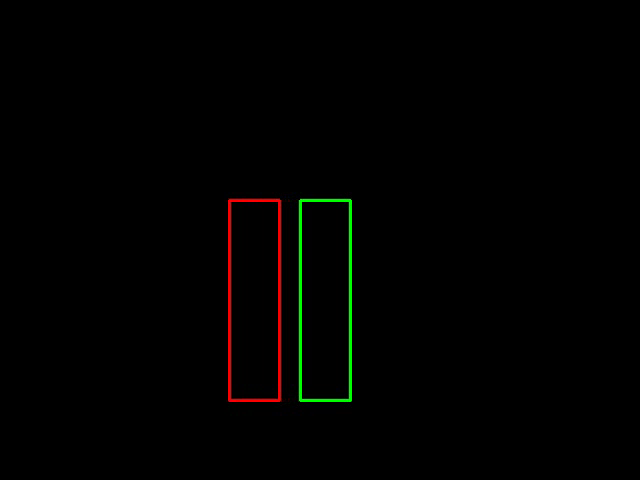


0: 480x640 (no detections), 9.5ms
Speed: 2.3ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


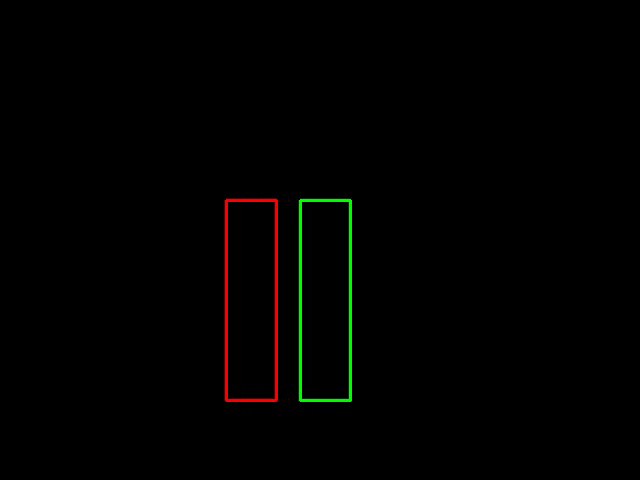


0: 480x640 (no detections), 9.2ms
Speed: 2.4ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


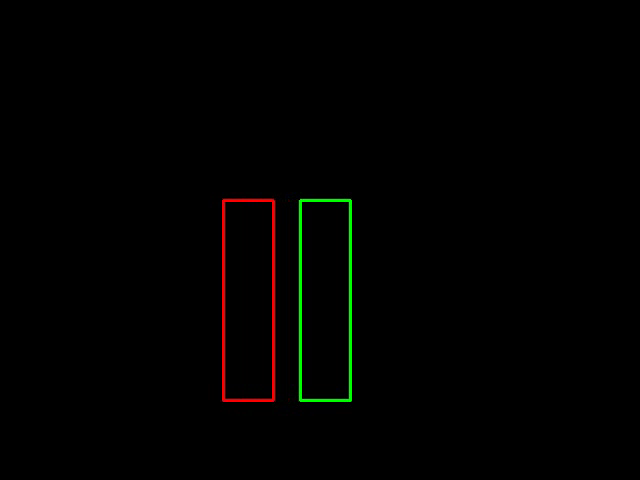


0: 480x640 (no detections), 9.3ms
Speed: 2.1ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


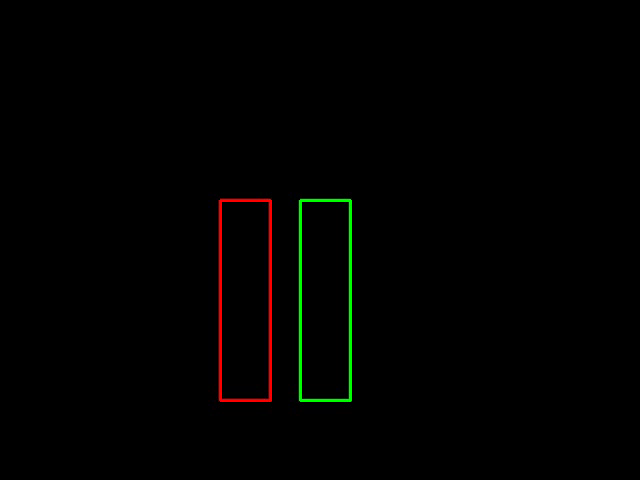


0: 480x640 (no detections), 9.1ms
Speed: 2.1ms preprocess, 9.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


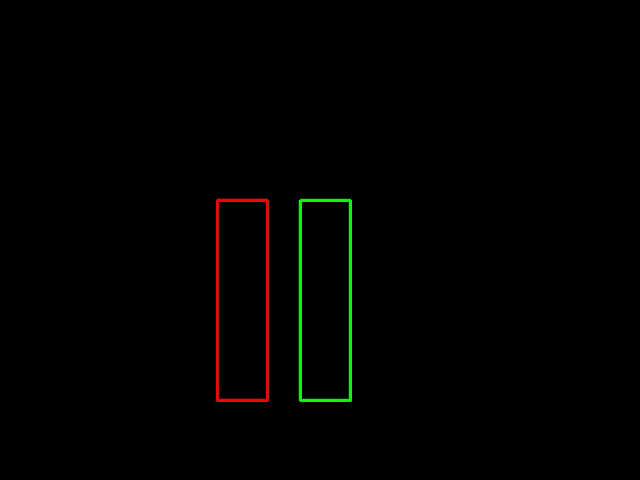


0: 480x640 (no detections), 9.7ms
Speed: 2.0ms preprocess, 9.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


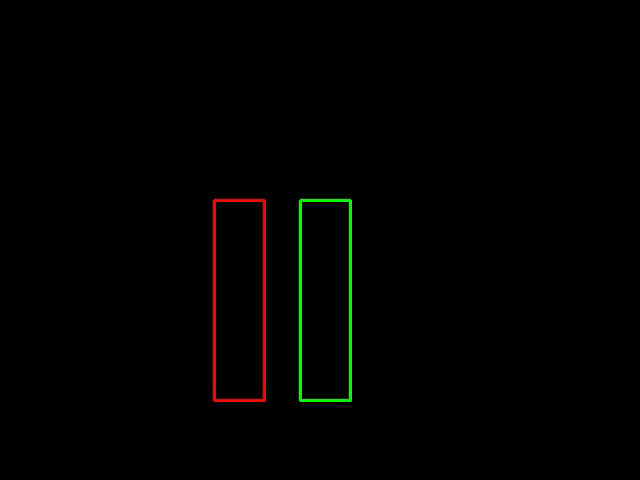


0: 480x640 (no detections), 9.9ms
Speed: 2.2ms preprocess, 9.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


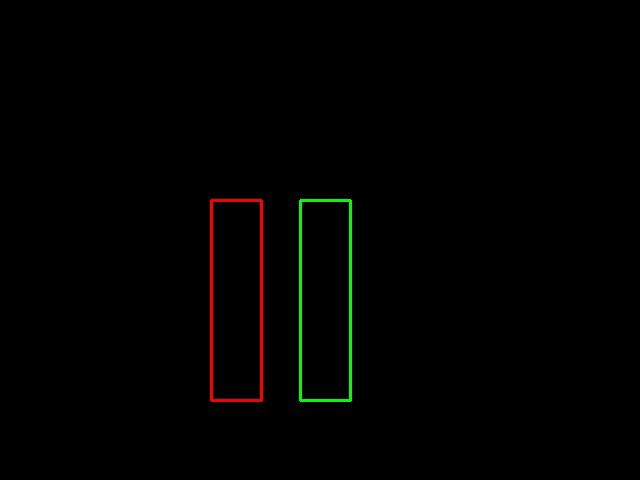


0: 480x640 (no detections), 9.4ms
Speed: 2.0ms preprocess, 9.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


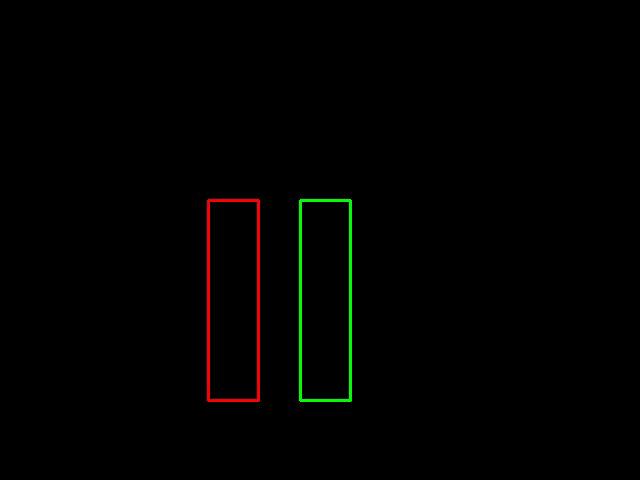


0: 480x640 (no detections), 9.3ms
Speed: 2.2ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


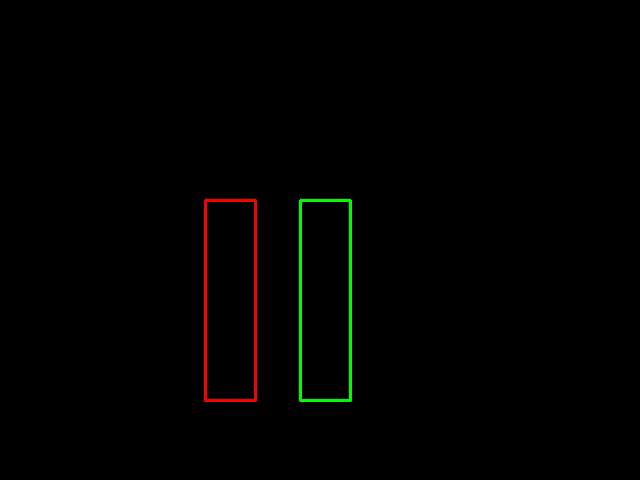


0: 480x640 (no detections), 11.9ms
Speed: 2.4ms preprocess, 11.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


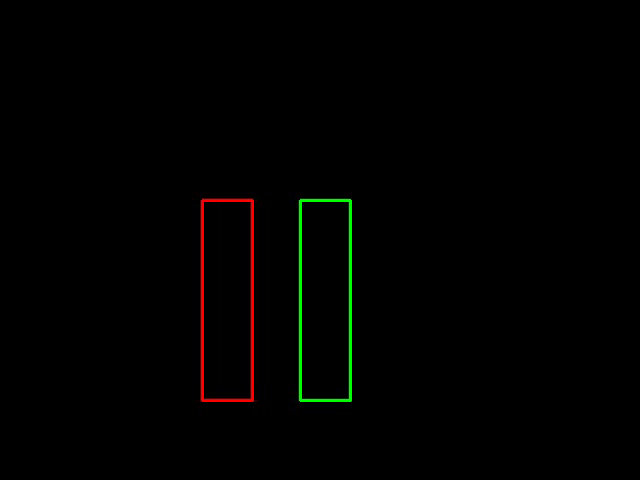


0: 480x640 (no detections), 9.7ms
Speed: 2.4ms preprocess, 9.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


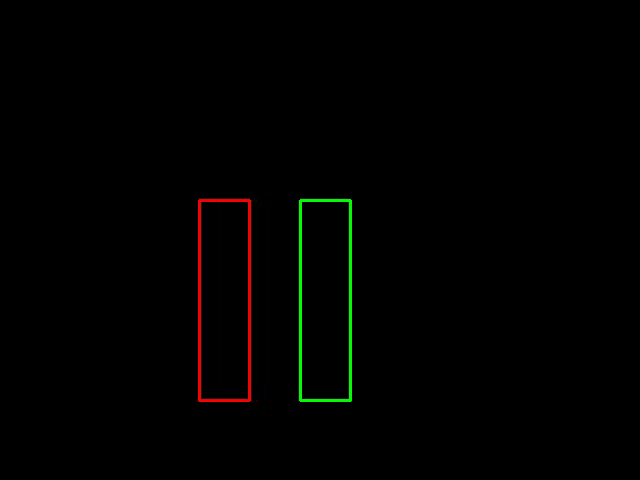


0: 480x640 (no detections), 14.9ms
Speed: 2.2ms preprocess, 14.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


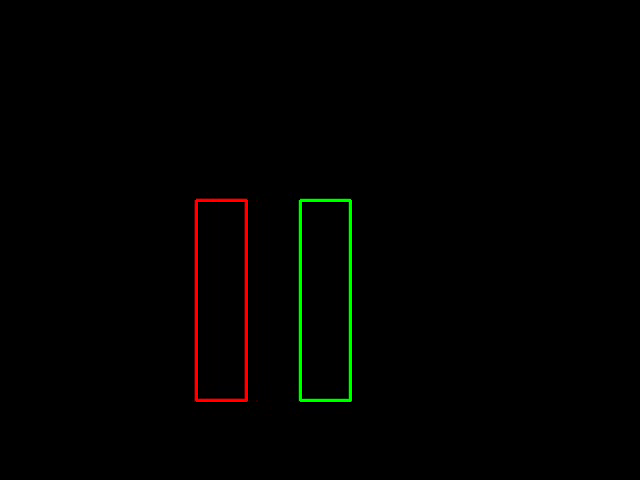


0: 480x640 (no detections), 15.6ms
Speed: 7.1ms preprocess, 15.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


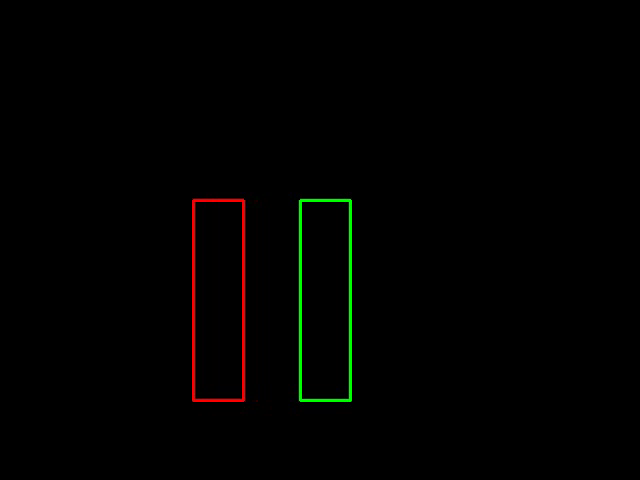


0: 480x640 (no detections), 10.5ms
Speed: 2.3ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


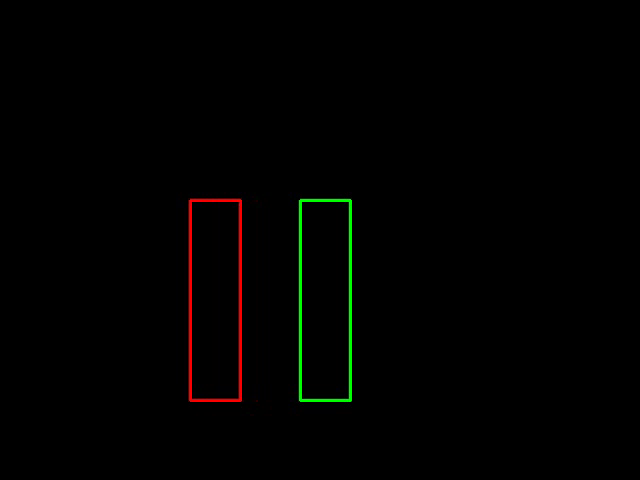


0: 480x640 (no detections), 9.0ms
Speed: 2.0ms preprocess, 9.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


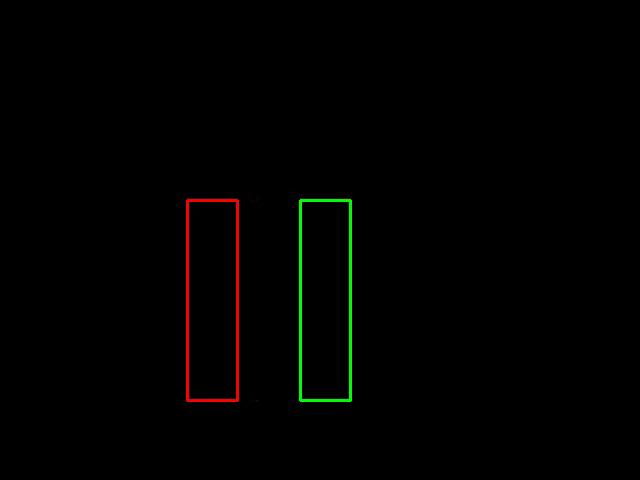


0: 480x640 (no detections), 9.2ms
Speed: 2.2ms preprocess, 9.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


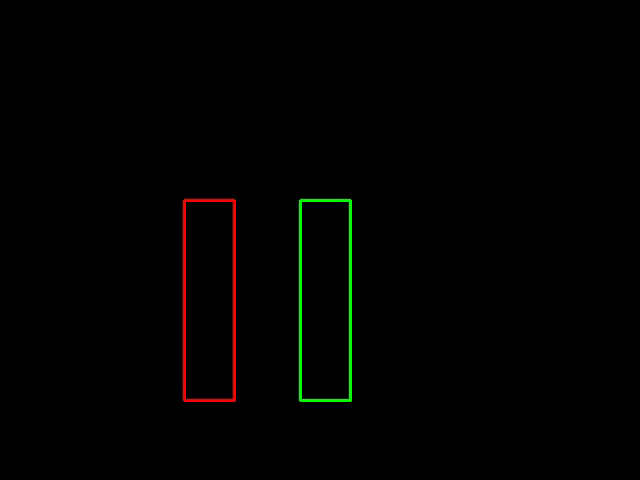


0: 480x640 (no detections), 9.5ms
Speed: 2.4ms preprocess, 9.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


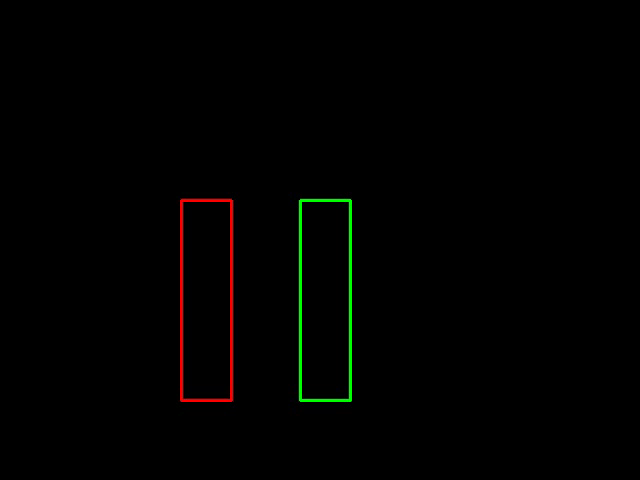


0: 480x640 (no detections), 9.3ms
Speed: 2.3ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


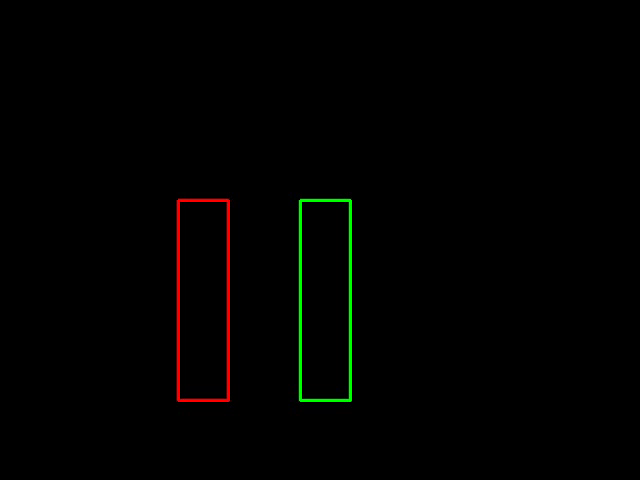


0: 480x640 (no detections), 9.3ms
Speed: 2.2ms preprocess, 9.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


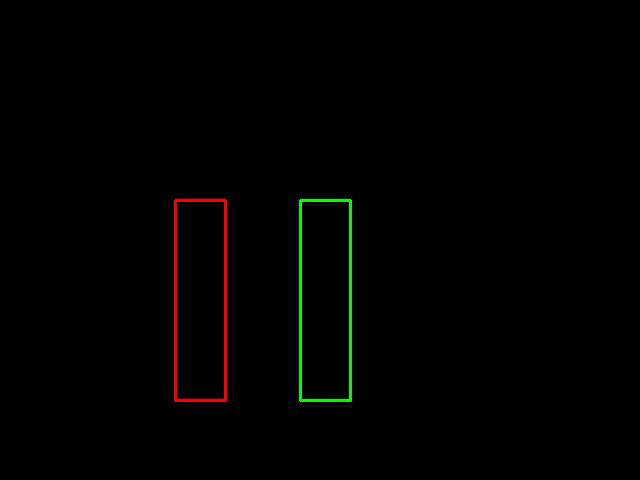


0: 480x640 (no detections), 9.3ms
Speed: 2.2ms preprocess, 9.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


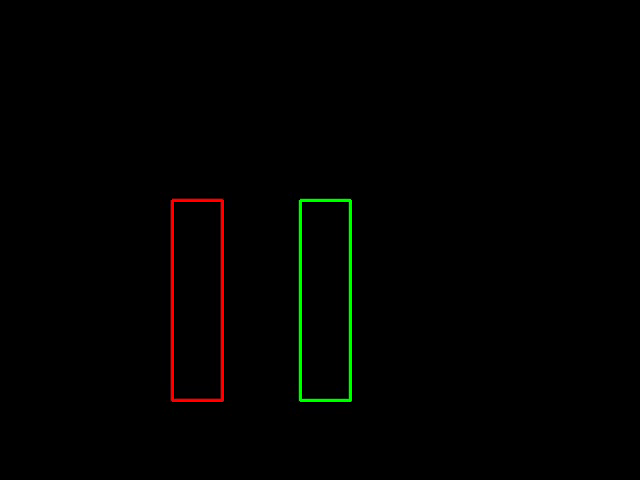


0: 480x640 (no detections), 9.2ms
Speed: 2.3ms preprocess, 9.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


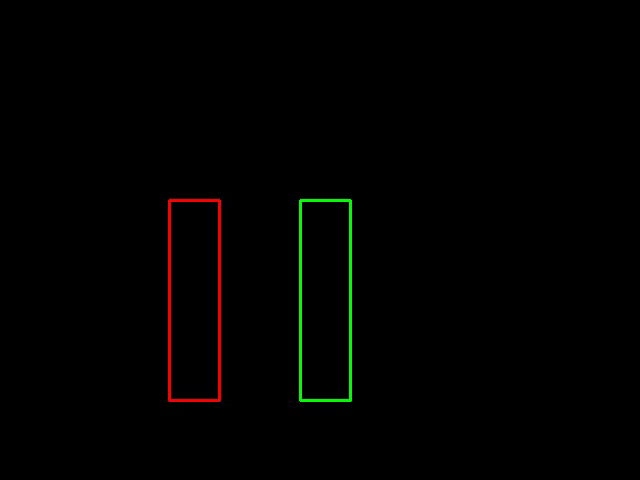


0: 480x640 (no detections), 11.0ms
Speed: 2.2ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


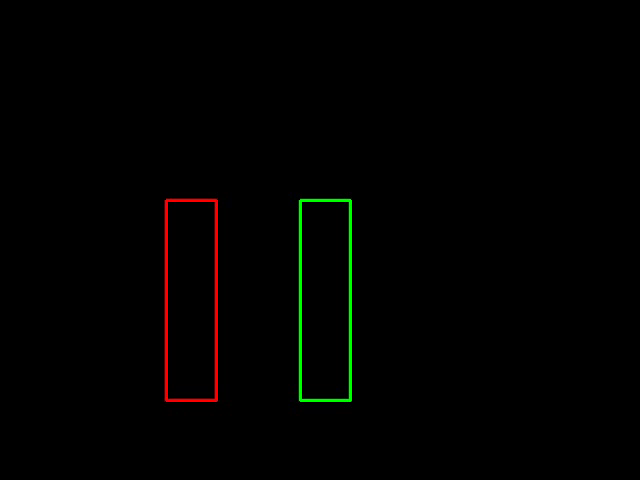


0: 480x640 (no detections), 11.1ms
Speed: 2.2ms preprocess, 11.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


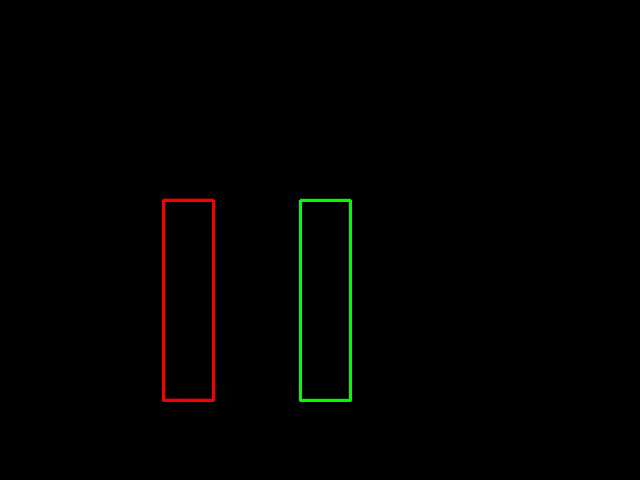


0: 480x640 (no detections), 10.1ms
Speed: 2.5ms preprocess, 10.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


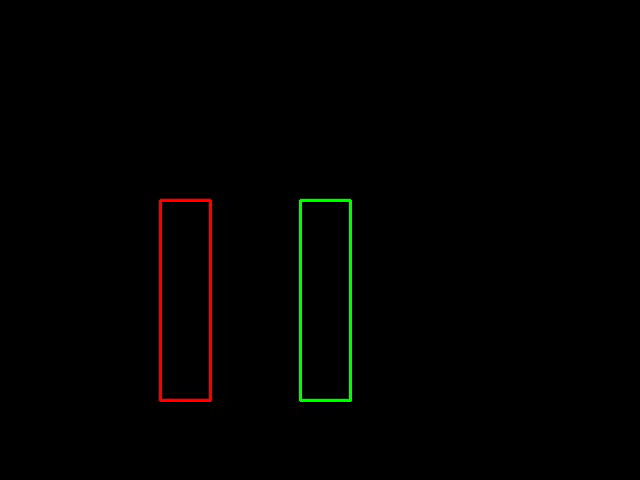


0: 480x640 (no detections), 9.2ms
Speed: 2.1ms preprocess, 9.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


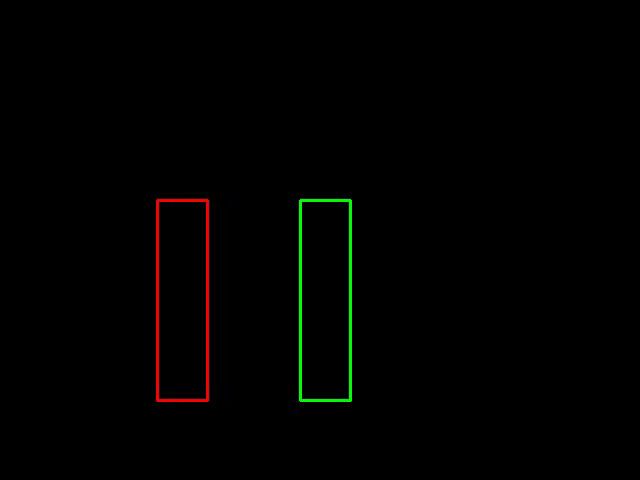


0: 480x640 (no detections), 9.3ms
Speed: 2.2ms preprocess, 9.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


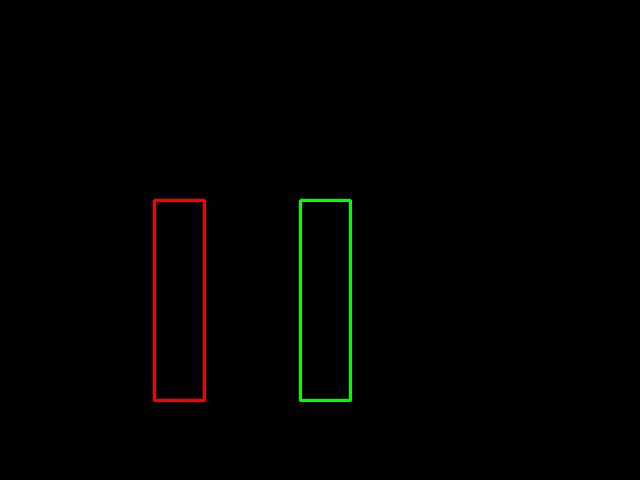


0: 480x640 (no detections), 9.3ms
Speed: 2.1ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


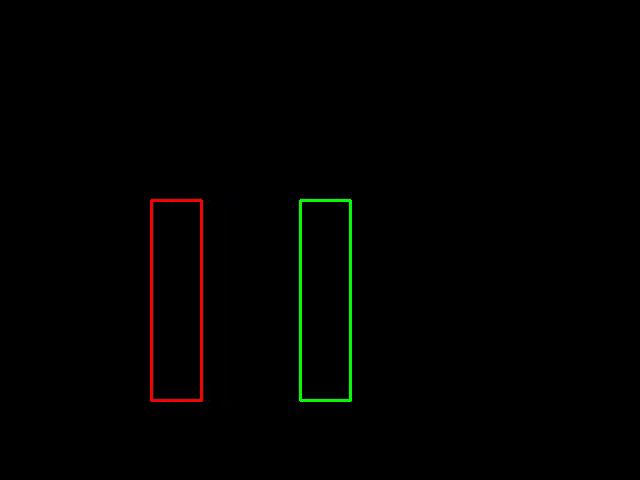


0: 480x640 (no detections), 9.3ms
Speed: 2.1ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


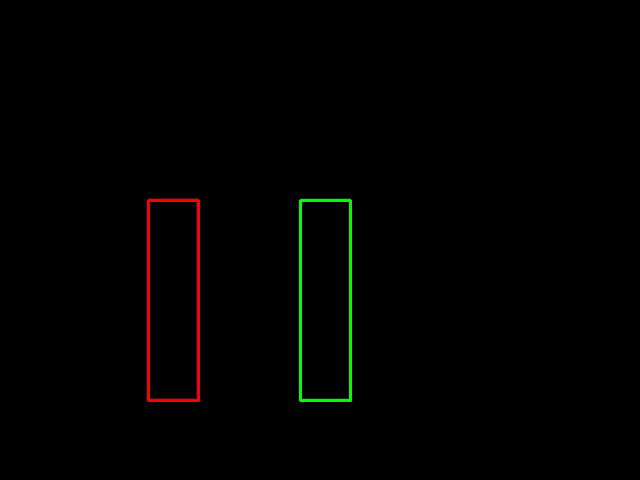


0: 480x640 (no detections), 9.3ms
Speed: 2.4ms preprocess, 9.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


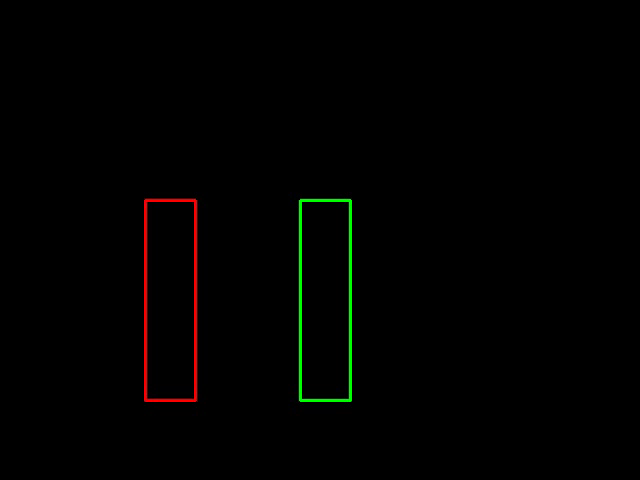


0: 480x640 (no detections), 10.0ms
Speed: 2.2ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


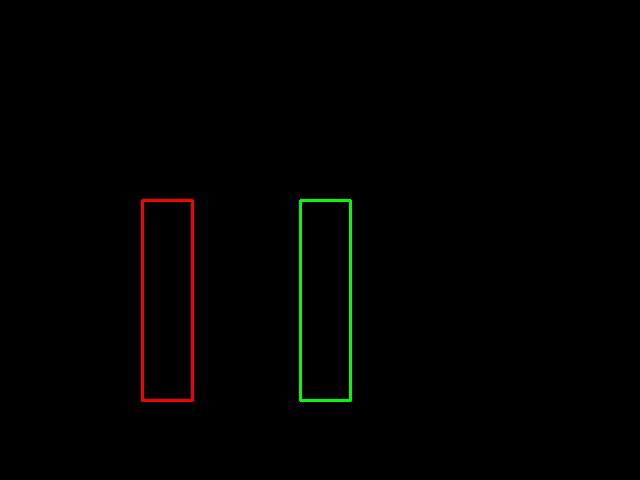


0: 480x640 (no detections), 10.8ms
Speed: 2.4ms preprocess, 10.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


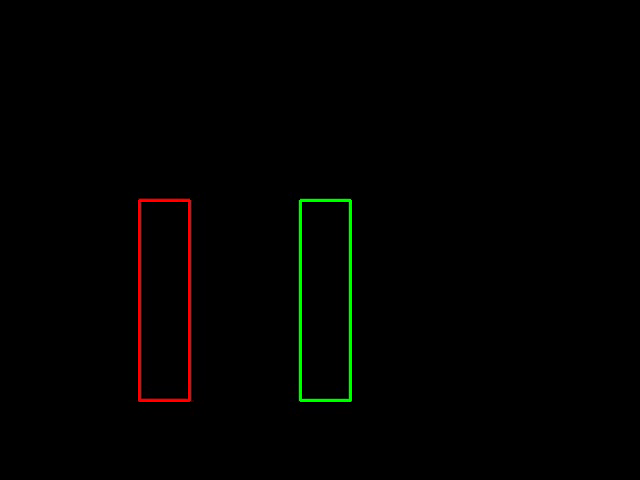


0: 480x640 (no detections), 9.2ms
Speed: 2.2ms preprocess, 9.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


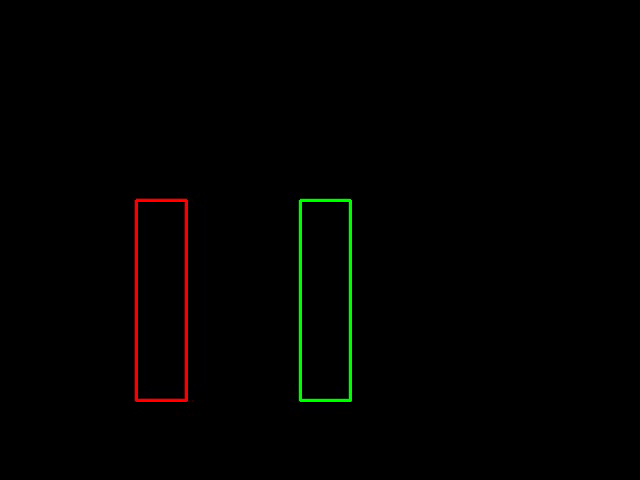


0: 480x640 (no detections), 9.3ms
Speed: 2.1ms preprocess, 9.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


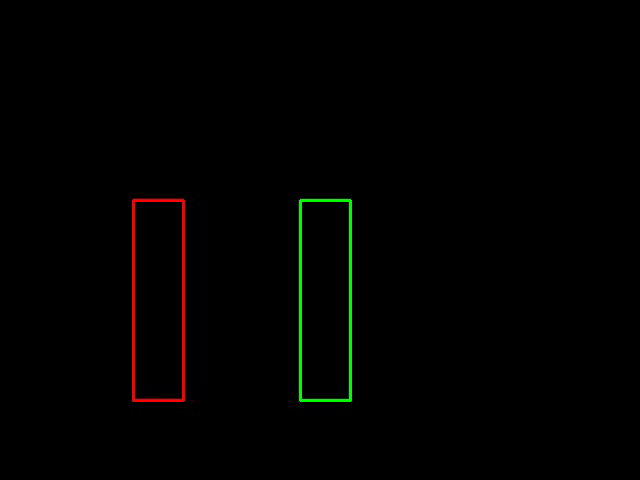


0: 480x640 (no detections), 9.6ms
Speed: 2.2ms preprocess, 9.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


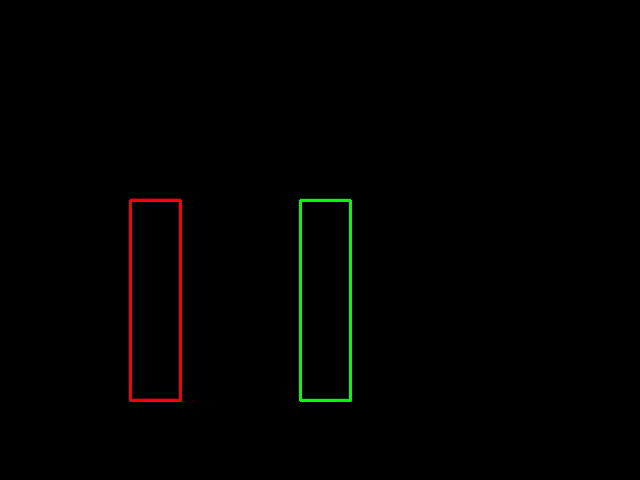


0: 480x640 (no detections), 10.0ms
Speed: 2.2ms preprocess, 10.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


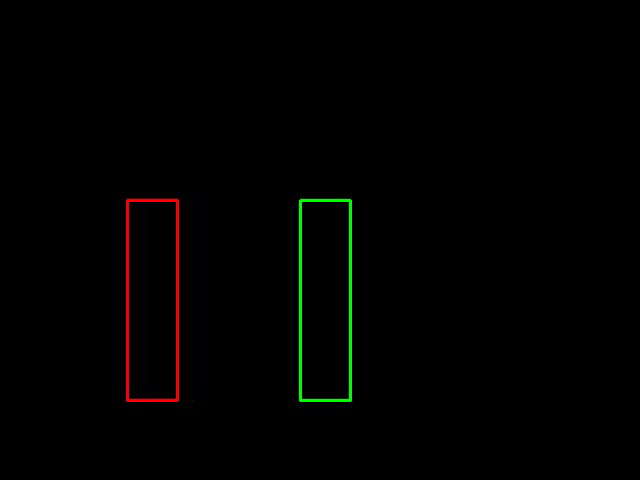


0: 480x640 (no detections), 9.2ms
Speed: 2.2ms preprocess, 9.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


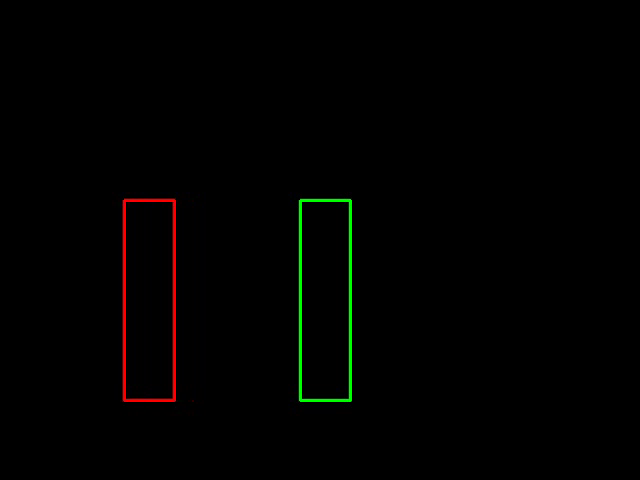


0: 480x640 (no detections), 9.7ms
Speed: 2.1ms preprocess, 9.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


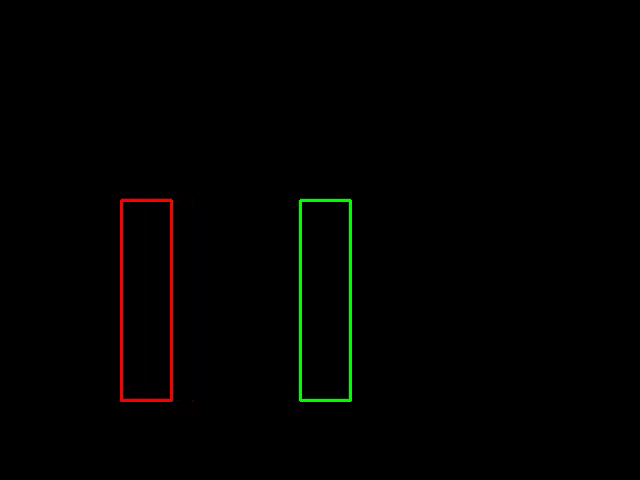


0: 480x640 (no detections), 9.4ms
Speed: 2.3ms preprocess, 9.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


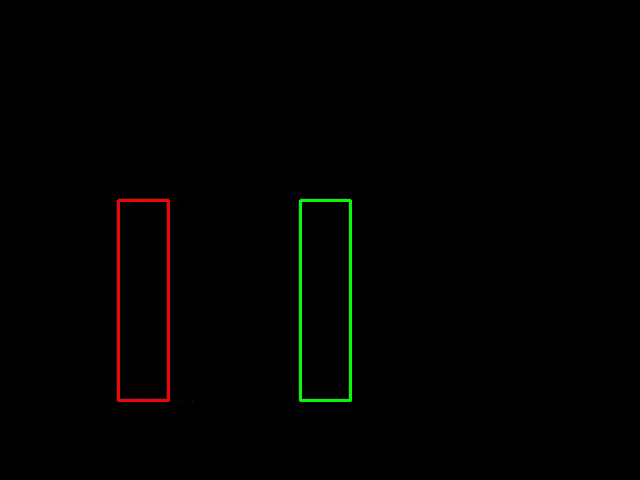


0: 480x640 (no detections), 15.7ms
Speed: 2.2ms preprocess, 15.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


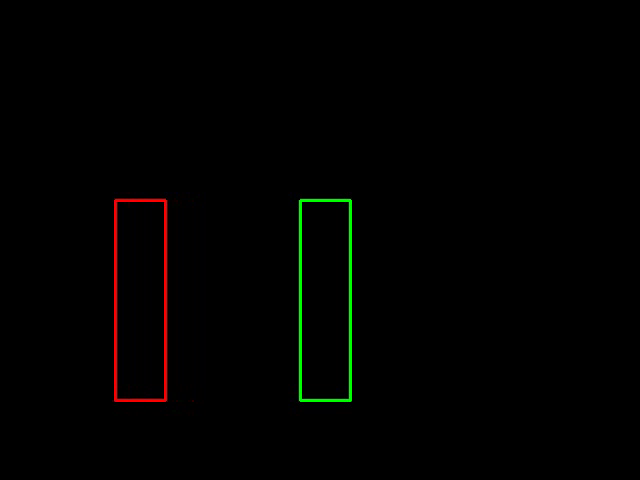


0: 480x640 (no detections), 10.4ms
Speed: 2.2ms preprocess, 10.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


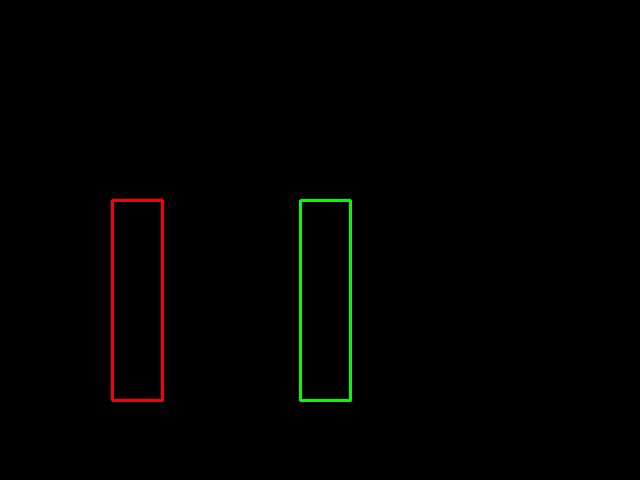


0: 480x640 (no detections), 10.0ms
Speed: 2.2ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


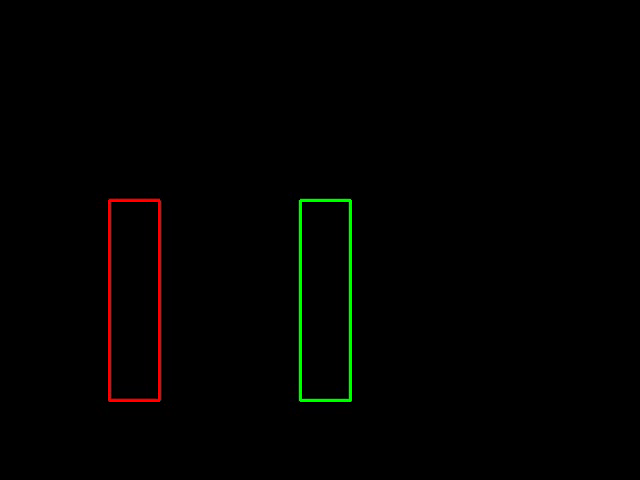


0: 480x640 (no detections), 10.0ms
Speed: 3.0ms preprocess, 10.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


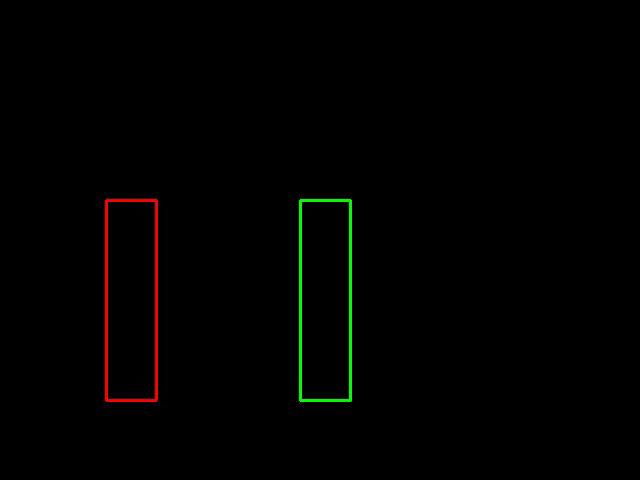


0: 480x640 (no detections), 9.6ms
Speed: 2.3ms preprocess, 9.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


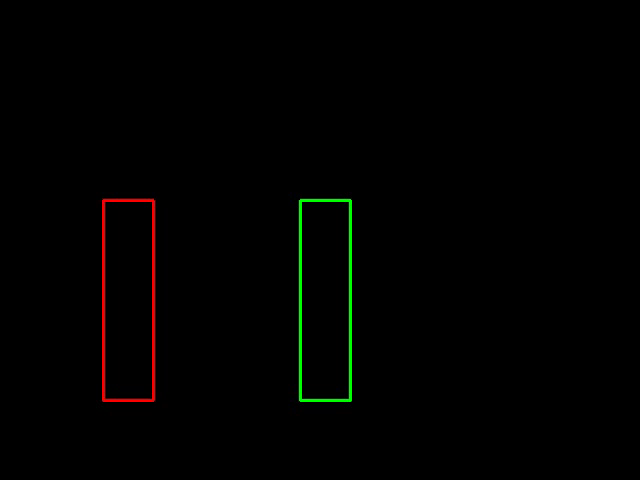

In [ ]:
from google.colab.patches import cv2_imshow  # Import Colab-safe display
import cv2

cap = cv2.VideoCapture("data/sample_video.mp4")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Detect people
    people = detect_people(frame)
    tracks = track_people(frame, people)
    stalkers = check_stalker(tracks)

    for track_id, bbox in tracks:
        x1, y1, x2, y2 = bbox
        cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 255, 0), 2)
        cv2.putText(frame, f"ID: {track_id}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 255), 1)

    for a, b in stalkers:
        cv2.putText(frame, f"Stalking: {a} → {b}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

    # Show frame (Colab-safe)
    cv2_imshow(frame)
    cv2.waitKey(50)  # Delay to mimic playback speed

cap.release()



0: 480x640 (no detections), 13.8ms
Speed: 3.5ms preprocess, 13.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


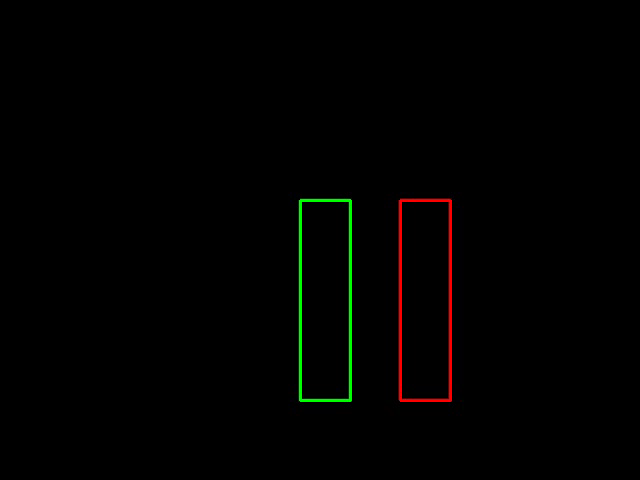


0: 480x640 (no detections), 32.4ms
Speed: 2.9ms preprocess, 32.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


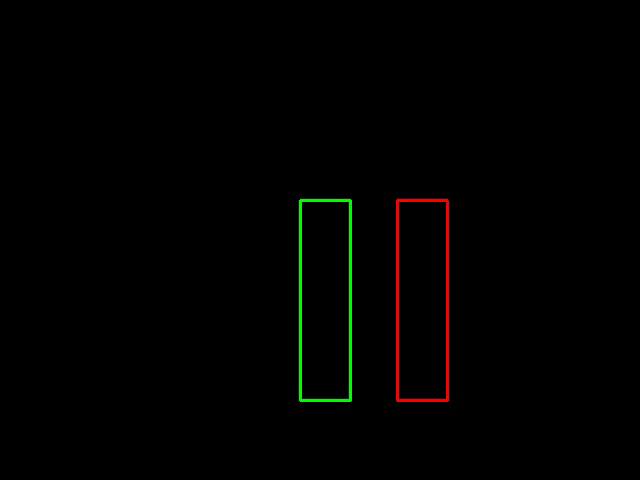


0: 480x640 (no detections), 30.8ms
Speed: 2.3ms preprocess, 30.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


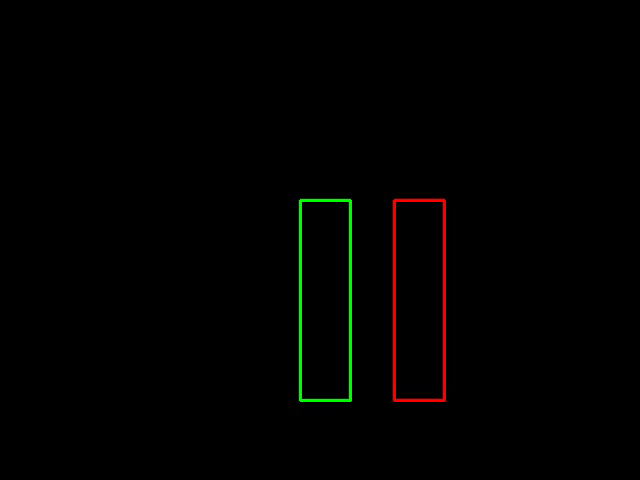


0: 480x640 (no detections), 23.8ms
Speed: 3.4ms preprocess, 23.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


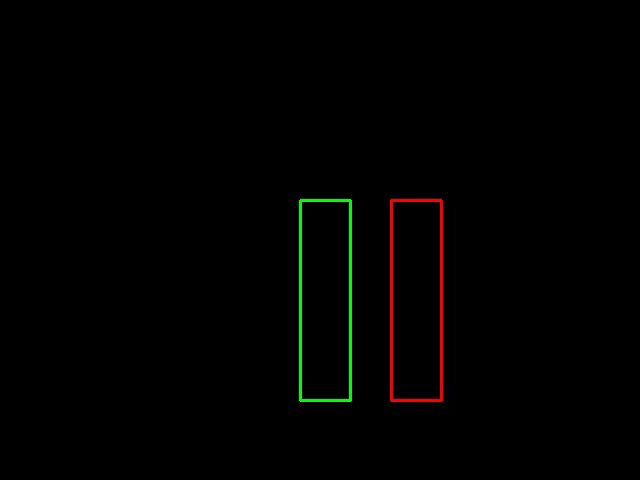


0: 480x640 (no detections), 23.7ms
Speed: 2.2ms preprocess, 23.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


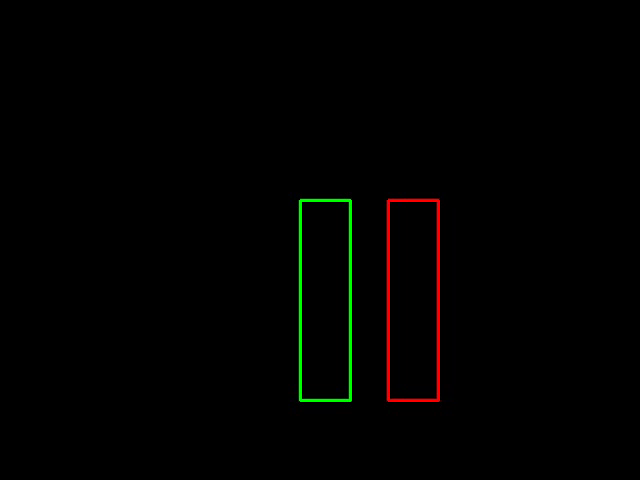


0: 480x640 (no detections), 8.7ms
Speed: 3.5ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


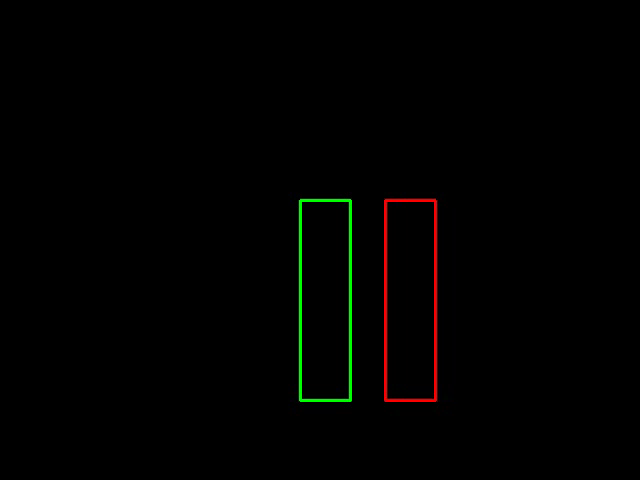


0: 480x640 (no detections), 7.8ms
Speed: 2.1ms preprocess, 7.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


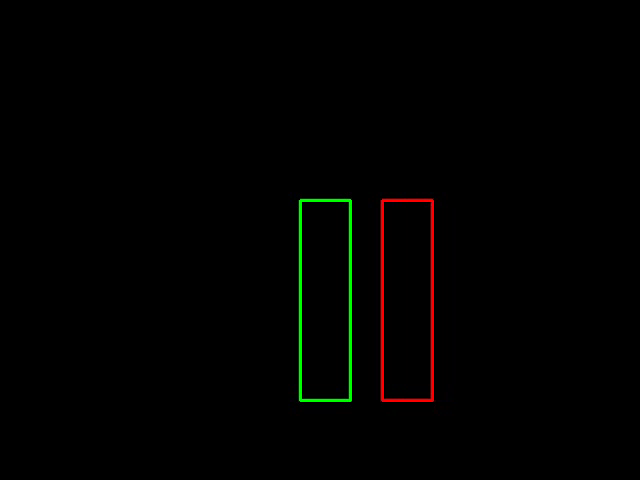


0: 480x640 (no detections), 9.7ms
Speed: 2.2ms preprocess, 9.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


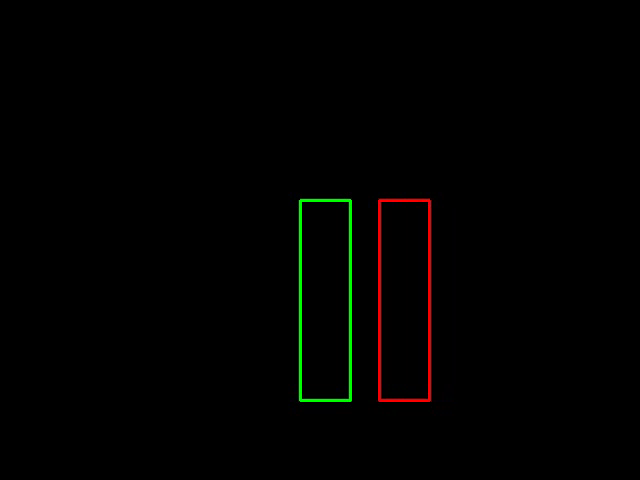


0: 480x640 (no detections), 8.7ms
Speed: 2.3ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


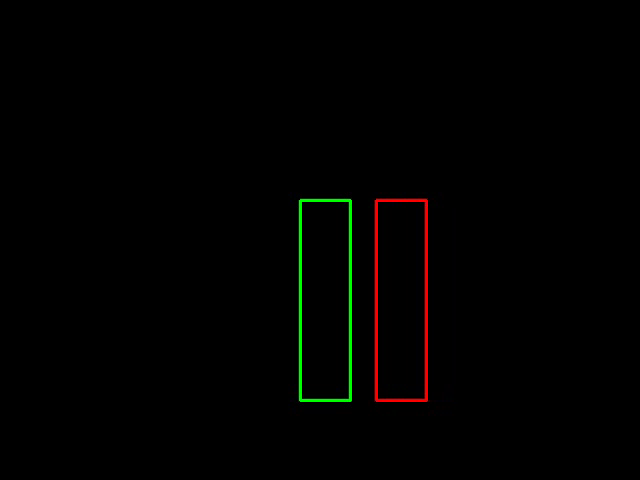


0: 480x640 (no detections), 9.3ms
Speed: 2.3ms preprocess, 9.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


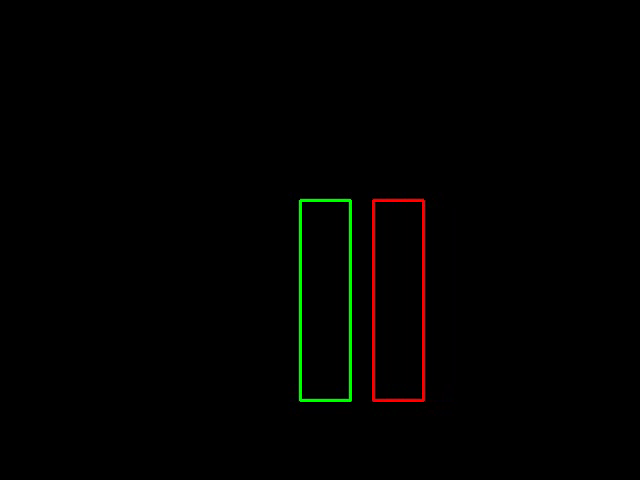


0: 480x640 (no detections), 8.8ms
Speed: 2.2ms preprocess, 8.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


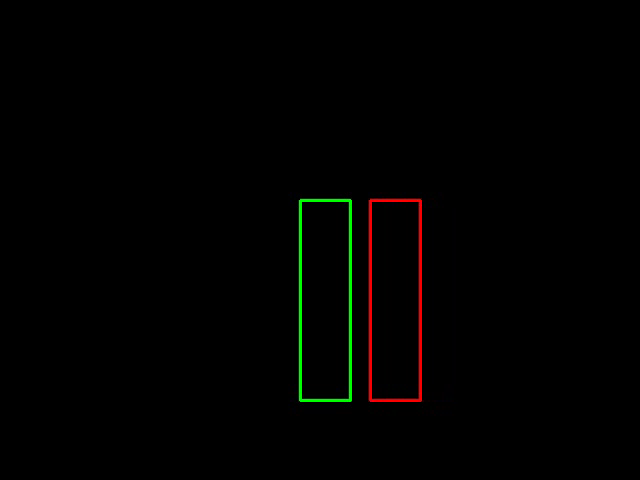


0: 480x640 (no detections), 10.3ms
Speed: 2.2ms preprocess, 10.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


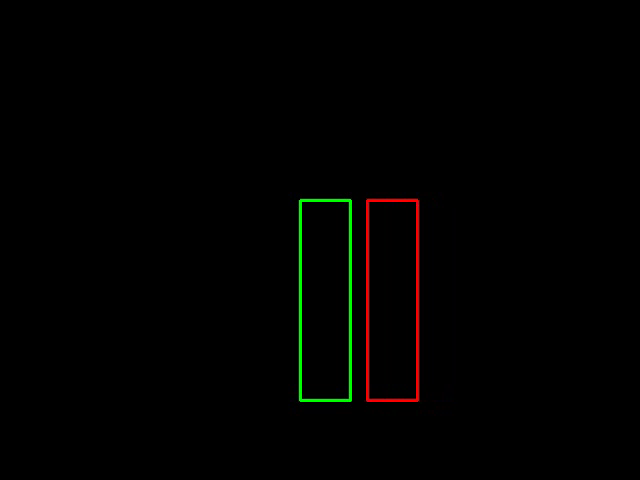


0: 480x640 (no detections), 9.1ms
Speed: 2.2ms preprocess, 9.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


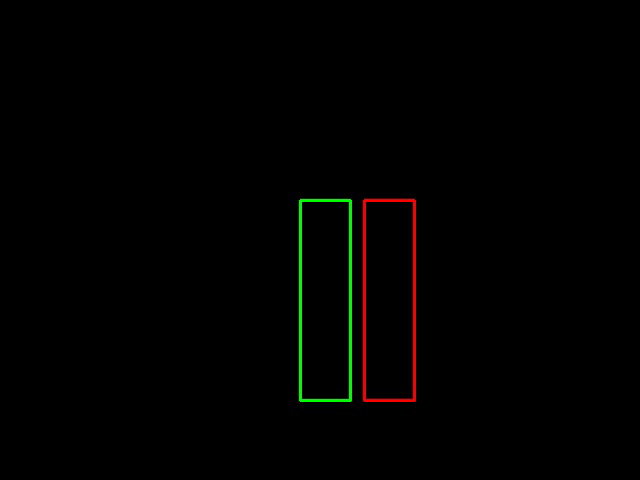


0: 480x640 (no detections), 11.2ms
Speed: 2.0ms preprocess, 11.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


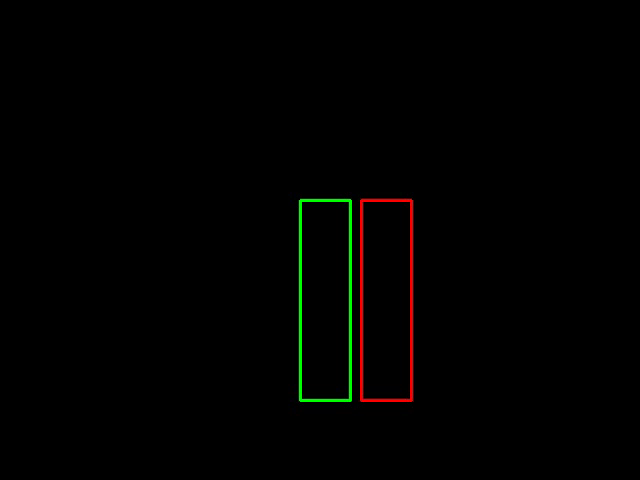


0: 480x640 (no detections), 9.6ms
Speed: 2.2ms preprocess, 9.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


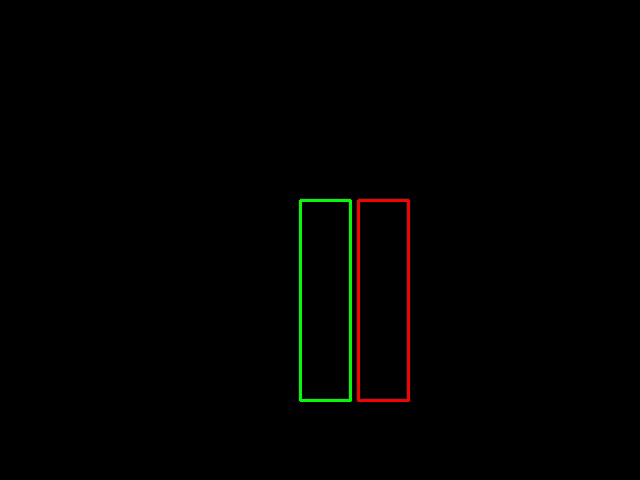


0: 480x640 (no detections), 10.5ms
Speed: 2.4ms preprocess, 10.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


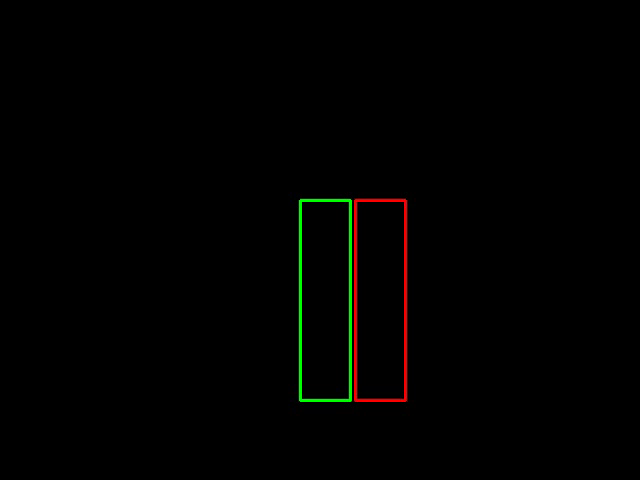


0: 480x640 (no detections), 10.8ms
Speed: 2.0ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


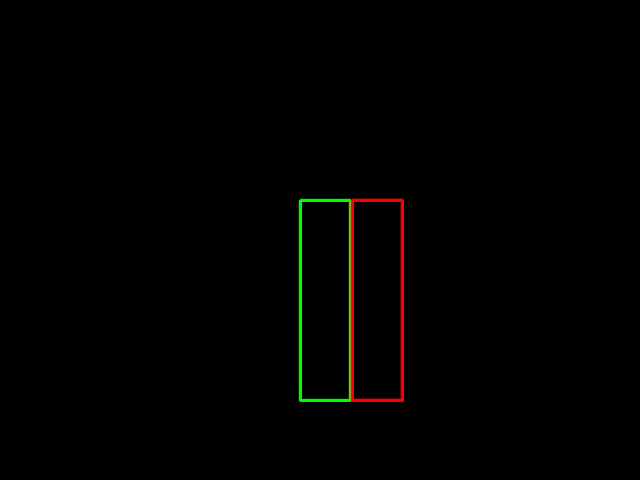


0: 480x640 (no detections), 9.8ms
Speed: 2.1ms preprocess, 9.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


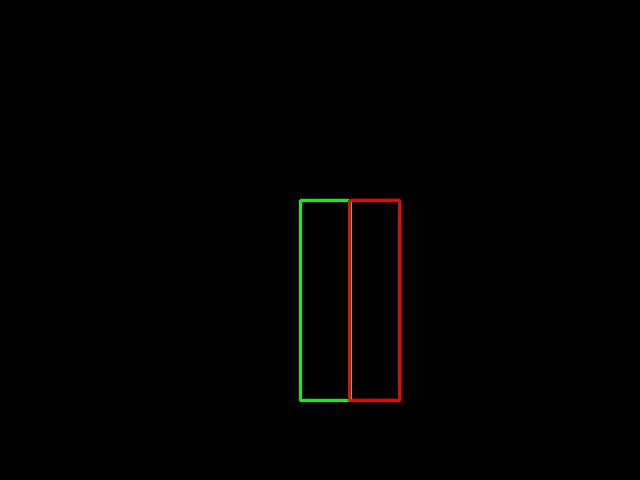


0: 480x640 (no detections), 8.9ms
Speed: 2.3ms preprocess, 8.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


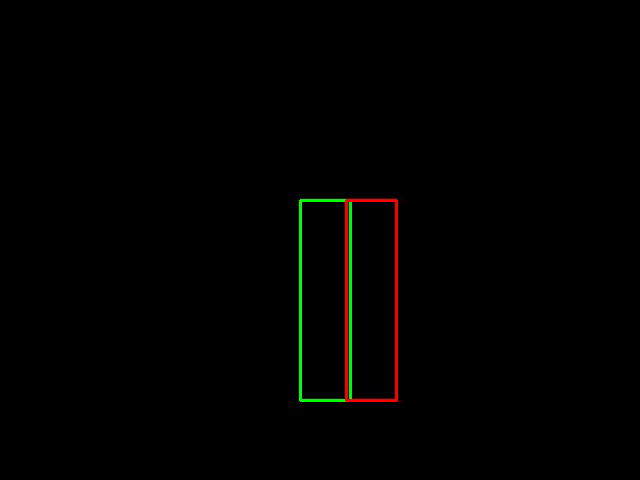


0: 480x640 (no detections), 10.9ms
Speed: 2.2ms preprocess, 10.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


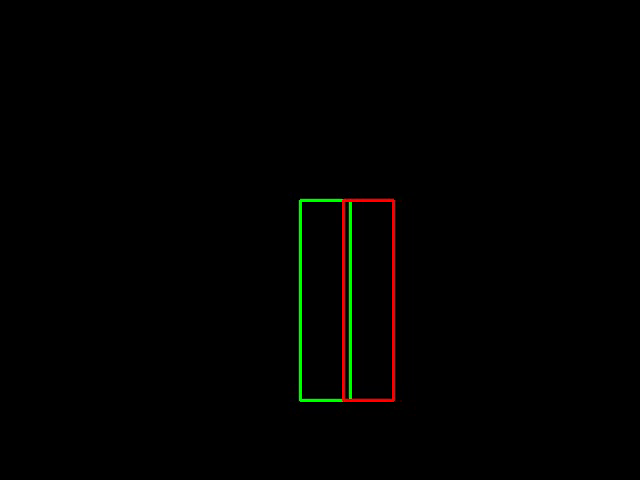


0: 480x640 (no detections), 10.0ms
Speed: 2.2ms preprocess, 10.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


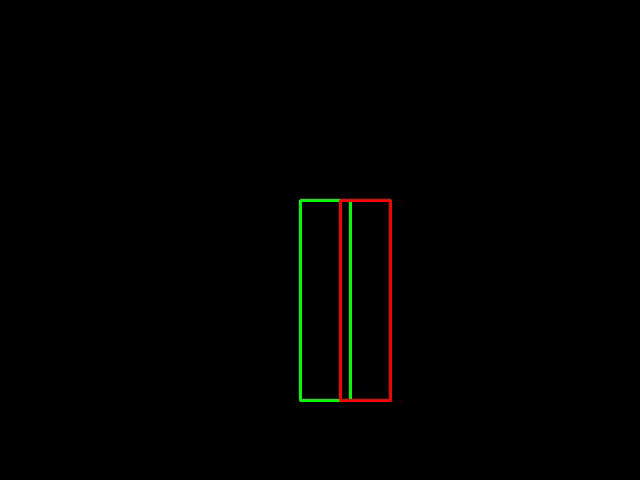


0: 480x640 (no detections), 10.7ms
Speed: 2.3ms preprocess, 10.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


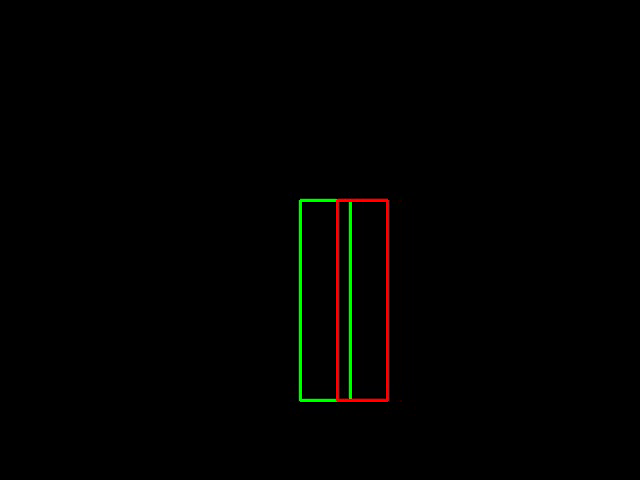


0: 480x640 (no detections), 10.3ms
Speed: 2.3ms preprocess, 10.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


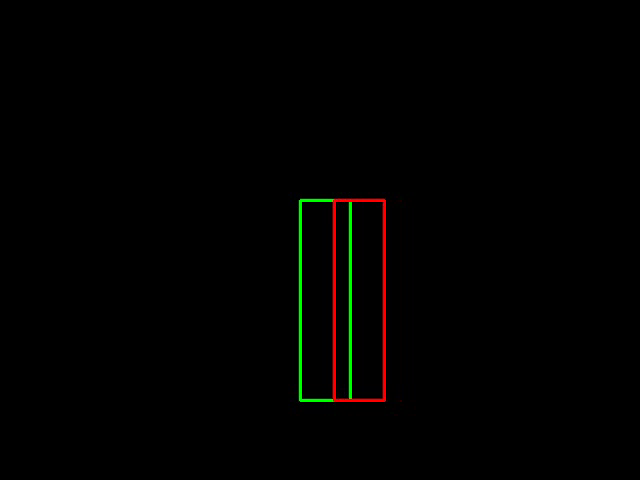


0: 480x640 (no detections), 12.1ms
Speed: 2.6ms preprocess, 12.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


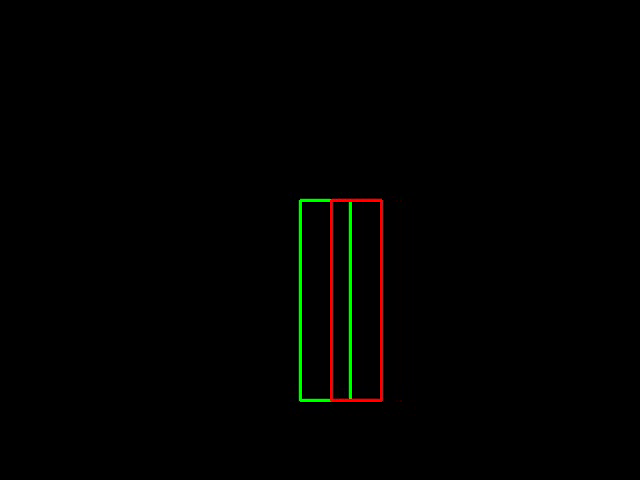


0: 480x640 (no detections), 11.7ms
Speed: 2.3ms preprocess, 11.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


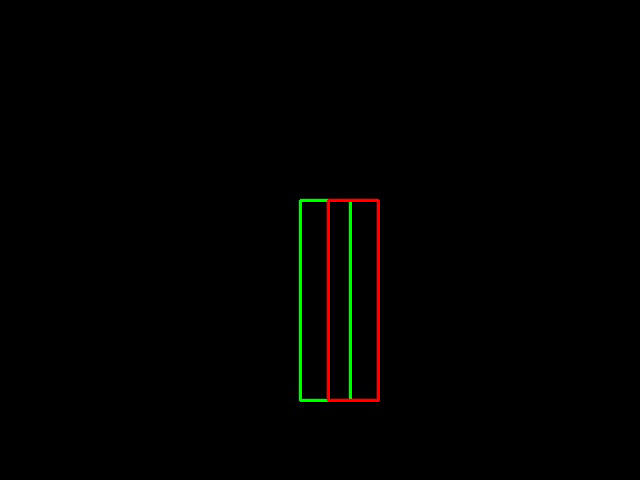


0: 480x640 (no detections), 9.5ms
Speed: 2.3ms preprocess, 9.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


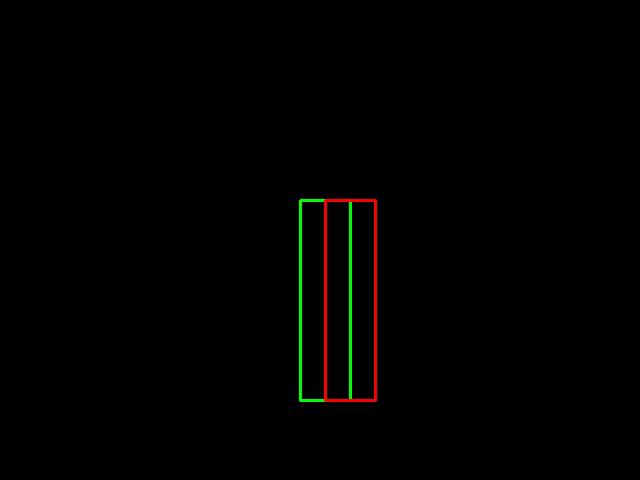


0: 480x640 (no detections), 10.0ms
Speed: 2.1ms preprocess, 10.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


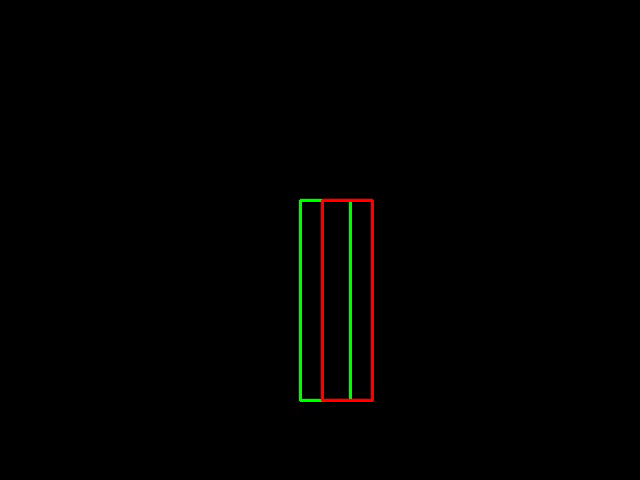


0: 480x640 (no detections), 11.1ms
Speed: 2.1ms preprocess, 11.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


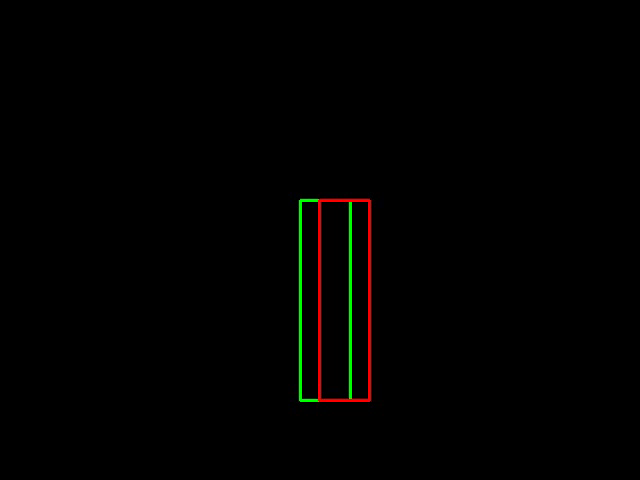


0: 480x640 (no detections), 10.5ms
Speed: 2.1ms preprocess, 10.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


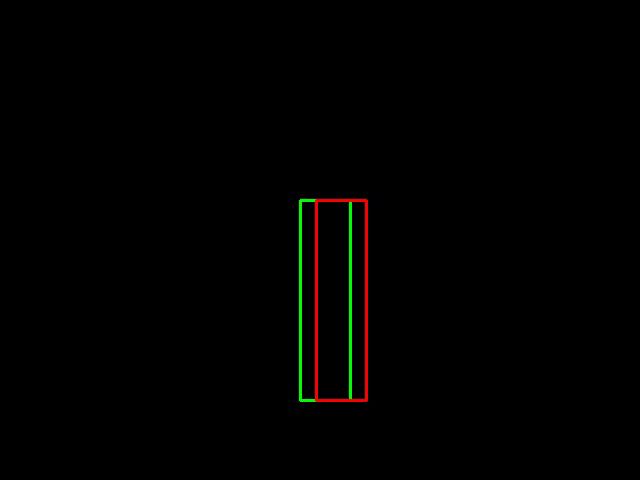


0: 480x640 (no detections), 12.0ms
Speed: 2.2ms preprocess, 12.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


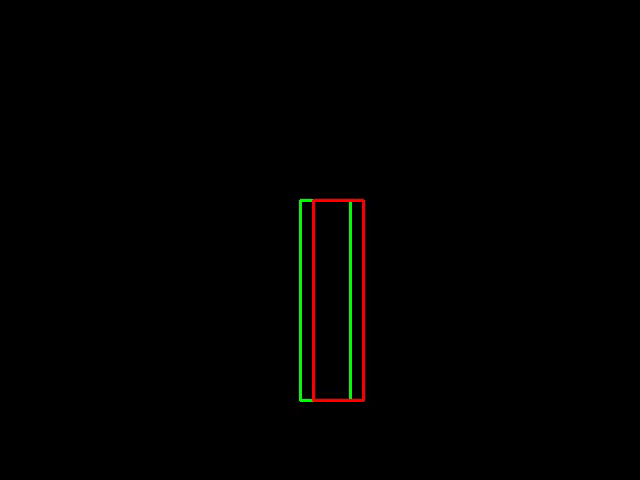

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import time

cap = cv2.VideoCapture("data/sample_video.mp4")

frame_count = 0
while cap.isOpened() and frame_count < 30:  # limit to 30 frames for display clarity
    ret, frame = cap.read()
    if not ret:
        break

    # Detect people
    people = detect_people(frame)
    tracks = track_people(frame, people)
    stalkers = check_stalker(tracks)

    for track_id, bbox in tracks:
        x1, y1, x2, y2 = bbox
        cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 255, 0), 2)
        cv2.putText(frame, f"ID: {track_id}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 255), 1)

    for a, b in stalkers:
        cv2.putText(frame, f"Stalking Detected: {a} → {b}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

    # Display frame in Colab
    cv2_imshow(frame)
    time.sleep(0.1)  # to slow down for readable output
    frame_count += 1

cap.release()


In [ ]:
!pip install ultralytics==8.0.0 opencv-python-headless==4.5.5.64 deep-sort-realtime==1.2.8 streamlit==1.12.0 numpy==1.23.5 sqlalchemy==1.4.41



ERROR: Ignored the following versions that require a different python version: 8.0.10 Requires-Python >=3.7,<=3.11; 8.0.11 Requires-Python >=3.7,<=3.11; 8.0.12 Requires-Python >=3.7,<=3.11; 8.0.13 Requires-Python >=3.7,<=3.11; 8.0.14 Requires-Python >=3.7,<=3.11; 8.0.15 Requires-Python >=3.7,<=3.11; 8.0.16 Requires-Python >=3.7,<=3.11; 8.0.17 Requires-Python >=3.7,<=3.11; 8.0.18 Requires-Python >=3.7,<=3.11; 8.0.19 Requires-Python >=3.7,<=3.11; 8.0.20 Requires-Python >=3.7,<=3.11; 8.0.21 Requires-Python >=3.7,<=3.11; 8.0.22 Requires-Python >=3.7,<=3.11; 8.0.23 Requires-Python >=3.7,<=3.11; 8.0.24 Requires-Python >=3.7,<=3.11; 8.0.25 Requires-Python >=3.7,<=3.11; 8.0.26 Requires-Python >=3.7,<=3.11; 8.0.27 Requires-Python >=3.7,<=3.11; 8.0.28 Requires-Python >=3.7,<=3.11; 8.0.29 Requires-Python >=3.7,<=3.11; 8.0.30 Requires-Python >=3.7,<=3.11; 8.0.31 Requires-Python >=3.7,<=3.11; 8.0.32 Requires-Python >=3.7,<=3.11; 8.0.33 Requires-Python >=3.7,<=3.11; 8.0.34 Requires-Python >=3.7,<=3.

In [ ]:
!pip install ultralytics
!pip install opencv-python-headless
!pip install deep-sort-realtime==1.3.2
!pip install streamlit numpy sqlalchemy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/102.mp4


/content/drive/MyDrive/102.mp4


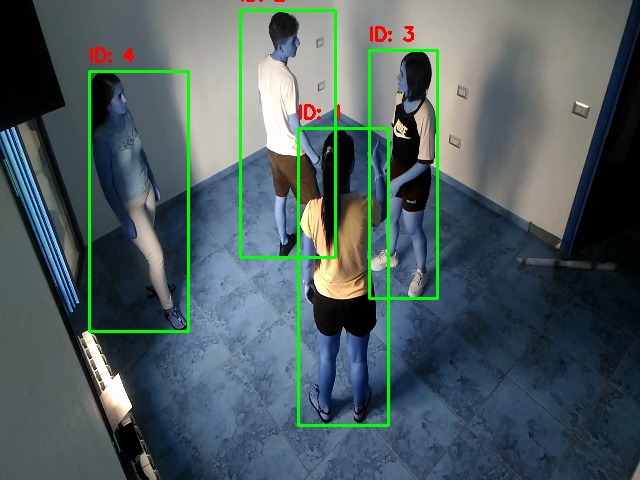

In [ ]:
from ultralytics import YOLO
import cv2
import numpy as np
from deep_sort_realtime.deepsort_tracker import DeepSort
from IPython.display import display, clear_output
from PIL import Image
import io

# Initialize YOLOv8 and DeepSORT
model = YOLO('yolov8n.pt')
tracker = DeepSort(max_age=10)

# Load video from Google Drive
video_path = '/content/drive/MyDrive/102.mp4'
cap = cv2.VideoCapture(video_path)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.resize(frame, (640, 480))

    # Run YOLO
    results = model(frame, conf=0.5)[0]
    boxes = results.boxes.xyxy.cpu().numpy()
    classes = results.boxes.cls.cpu().numpy().astype(int)

    # Prepare person detections for DeepSORT
    detections = []
    for i, cls in enumerate(classes):
        if cls == 0:  # person
            x1, y1, x2, y2 = map(int, boxes[i])
            detections.append(([x1, y1, x2 - x1, y2 - y1], 1.0, 'person'))

    tracks = tracker.update_tracks(detections, frame=frame)

    # Draw tracked objects
    for track in tracks:
        if not track.is_confirmed():
            continue
        l, t, r, b = map(int, track.to_ltrb())
        track_id = track.track_id
        cv2.rectangle(frame, (l, t), (r, b), (0, 255, 0), 2)
        cv2.putText(frame, f'ID: {track_id}', (l, t - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    # Show output in Colab
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    is_success, buffer = cv2.imencode(".jpg", rgb)
    if is_success:
        clear_output(wait=True)
        display(Image.open(io.BytesIO(buffer)))

cap.release()


In [ ]:
!ls /content/drive/MyDrive/Stalker.mp4


/content/drive/MyDrive/Stalker.mp4


In [ ]:
!pip install ultralytics
!pip install deep-sort-realtime


In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort
from collections import defaultdict, deque
from google.colab.patches import cv2_imshow
import time
import os

# Load model and tracker
model = YOLO("yolov8n.pt")
tracker = DeepSort(max_age=30)

# Load video from Google Drive
video_path = "/content/drive/MyDrive/stalker.mp4"
cap = cv2.VideoCapture(video_path)

# Output settings
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
out = cv2.VideoWriter("stalker_output.mp4", cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

# Tracking setup
track_history = defaultdict(lambda: deque(maxlen=50))  # ~10 sec if 5 fps
frame_count = 0
screenshot_saved = False

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    if frame_count % 5 != 0:
        continue

    results = model(frame, verbose=False)[0]
    boxes = results.boxes.xyxy.cpu().numpy()
    classes = results.boxes.cls.cpu().numpy().astype(int)

    person_boxes = []
    for box, cls in zip(boxes, classes):
        if cls == 0:
            x1, y1, x2, y2 = map(int, box)
            person_boxes.append(([x1, y1, x2 - x1, y2 - y1], 0.99, 'person'))

    tracks = tracker.update_tracks(person_boxes, frame=frame)
    centroids = {}

    for track in tracks:
        if not track.is_confirmed():
            continue
        tid = track.track_id
        bbox = track.to_ltrb()
        x1, y1, x2, y2 = map(int, bbox)
        center = ((x1 + x2) // 2, (y1 + y2) // 2)
        track_history[tid].append(center)
        centroids[tid] = (bbox, center)

    red_ids = set()
    for id1 in centroids:
        for id2 in centroids:
            if id1 == id2:
                continue
            if len(track_history[id1]) == 50 and len(track_history[id2]) == 50:
                distances = [
                    np.linalg.norm(np.array(track_history[id1][i]) - np.array(track_history[id2][i]))
                    for i in range(50)
                ]
                if all(dist < 70 for dist in distances):  # Stalker behavior
                    red_ids.update([id1, id2])

    for track in tracks:
        if not track.is_confirmed():
            continue
        tid = track.track_id
        bbox = track.to_ltrb()
        x1, y1, x2, y2 = map(int, bbox)

        if tid in red_ids:
            color = (0, 0, 255)
            label = f"Stalker ID: {tid}"
        else:
            color = (0, 255, 0)
            label = f"ID: {tid}"

        cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
        cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    # Save screenshot on detection
    if red_ids and not screenshot_saved:
        cv2.imwrite("/content/stalker_detected_frame.jpg", frame)
        screenshot_saved = True
        print("📸 Screenshot saved: stalker_detected_frame.jpg")

    out.write(frame)

    # Optional: Show preview in Colab
    if frame_count % 50 == 0:
        cv2_imshow(frame)

cap.release()
out.release()
print("✅ Detection complete. Video saved as stalker_output.mp4")


✅ Detection complete. Video saved as stalker_output.mp4


In [ ]:
video_path = "/content/drive/MyDrive/Stalker.mp4"  # or add folder if needed
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("❌ Error: Could not open video.")
else:
    print("✅ Video loaded successfully!")


✅ Video loaded successfully!


 21%|██▏       | 41/192 [00:01<00:02, 53.75it/s]

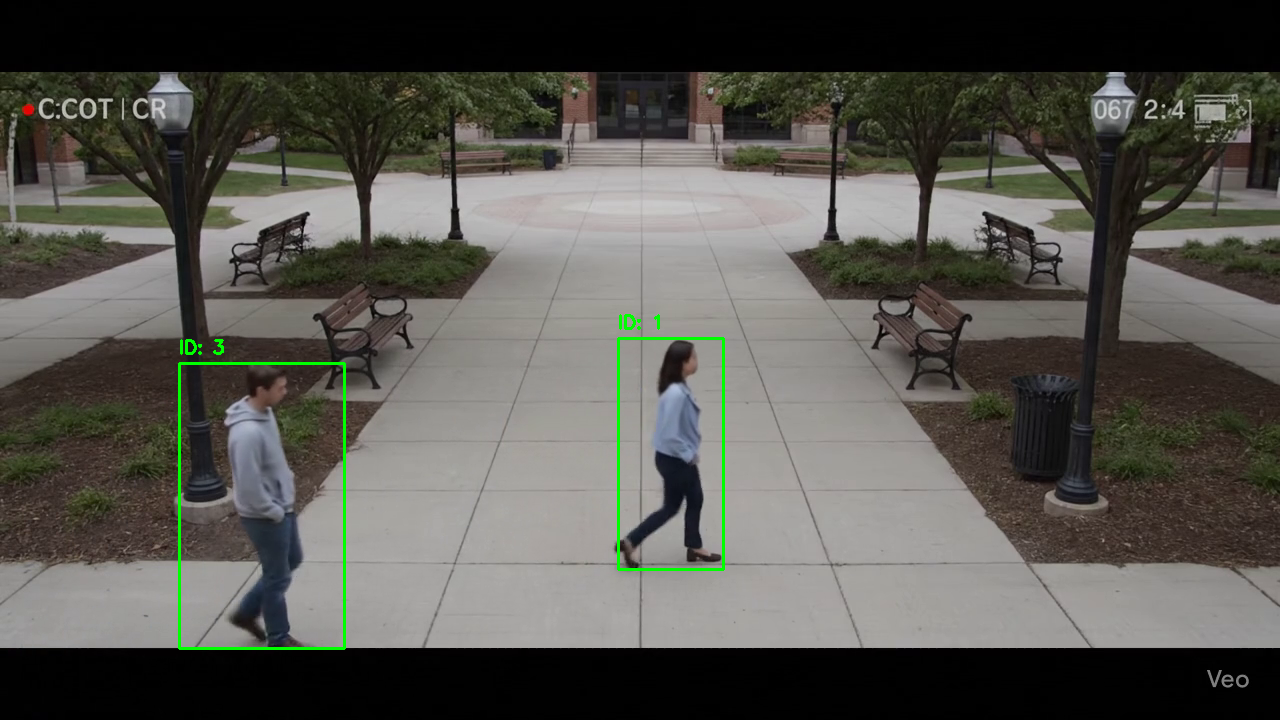

 52%|█████▏    | 99/192 [00:01<00:01, 87.85it/s]

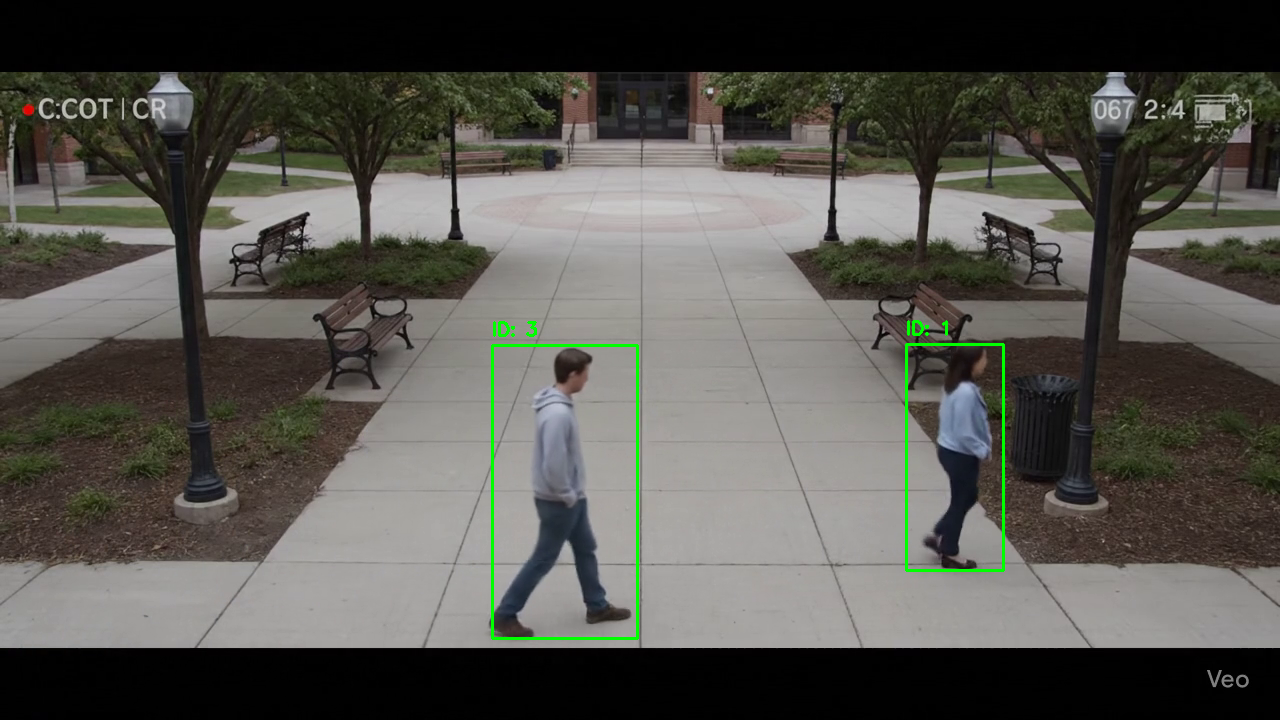

 76%|███████▌  | 146/192 [00:02<00:00, 81.40it/s]

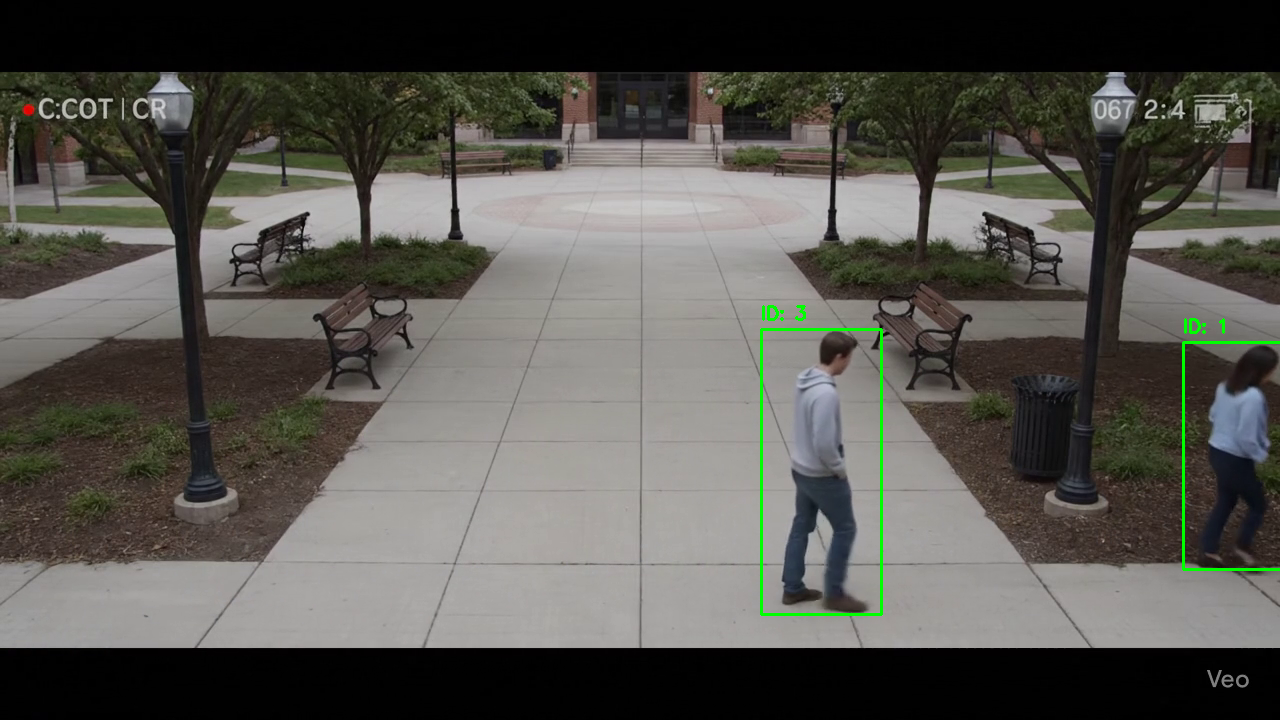

100%|██████████| 192/192 [00:03<00:00, 61.82it/s]

✅ Processing complete. Output saved as 'stalker_output.mp4'


In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort
from collections import defaultdict, deque
from google.colab.patches import cv2_imshow
from tqdm import tqdm
import os

# Load model and tracker
model = YOLO("yolov8n.pt")
tracker = DeepSort(max_age=30)

# Load video from Drive
video_path = "/content/drive/MyDrive/Stalker.mp4"
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    raise FileNotFoundError(f"❌ Could not open video at: {video_path}")

# Video output config
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
input_fps = int(cap.get(cv2.CAP_PROP_FPS))
output_fps = input_fps // 5  # Since we're processing 1 in 5 frames

out = cv2.VideoWriter("stalker_output.mp4", cv2.VideoWriter_fourcc(*'mp4v'), output_fps, (width, height))

# Tracking history
track_history = defaultdict(lambda: deque(maxlen=50))  # 50 frames at ~5 fps = 10s
frame_count = 0
screenshot_saved = False

# Progress bar setup
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
pbar = tqdm(total=total_frames)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    pbar.update(1)

    if frame_count % 5 != 0:
        continue  # Skip frames to simulate 5fps processing

    results = model(frame, verbose=False)[0]
    boxes = results.boxes.xyxy.cpu().numpy()
    classes = results.boxes.cls.cpu().numpy().astype(int)

    person_boxes = []
    for box, cls in zip(boxes, classes):
        if cls == 0:  # person class
            x1, y1, x2, y2 = map(int, box)
            person_boxes.append(([x1, y1, x2 - x1, y2 - y1], 0.99, 'person'))

    tracks = tracker.update_tracks(person_boxes, frame=frame)
    centroids = {}

    for track in tracks:
        if not track.is_confirmed():
            continue
        tid = track.track_id
        bbox = track.to_ltrb()
        x1, y1, x2, y2 = map(int, bbox)
        center = ((x1 + x2) // 2, (y1 + y2) // 2)
        track_history[tid].append(center)
        centroids[tid] = (bbox, center)

    # Detect "stalking" behavior
    red_ids = set()
    for id1 in centroids:
        for id2 in centroids:
            if id1 == id2:
                continue
            if len(track_history[id1]) == 50 and len(track_history[id2]) == 50:
                distances = [
                    np.linalg.norm(np.array(track_history[id1][i]) - np.array(track_history[id2][i]))
                    for i in range(50)
                ]
                if all(dist < 70 for dist in distances):  # <70 px ~ close proximity
                    red_ids.update([id1, id2])

    # Draw bounding boxes and labels
    for track in tracks:
        if not track.is_confirmed():
            continue
        tid = track.track_id
        bbox = track.to_ltrb()
        x1, y1, x2, y2 = map(int, bbox)

        if tid in red_ids:
            color = (0, 0, 255)  # Red for stalker
            label = f"Stalker ID: {tid}"
        else:
            color = (0, 255, 0)  # Green for normal
            label = f"ID: {tid}"

        cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
        cv2.putText(frame, label, (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    # Save screenshot if stalker detected
    if red_ids and not screenshot_saved:
        cv2.imwrite("/content/stalker_detected_frame.jpg", frame)
        screenshot_saved = True
        print("📸 Screenshot saved: /content/stalker_detected_frame.jpg")

    # Save the processed frame
    out.write(frame)

    # Optional: show every 50th processed frame
    if frame_count % 50 == 0:
        cv2_imshow(frame)

# Release resources
cap.release()
out.release()
pbar.close()

print("✅ Processing complete. Output saved as 'stalker_output.mp4'")


In [ ]:
from google.colab import files
files.download("stalker_output.mp4")
files.download("stalker_detected_frame.jpg")
